In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

from pandas.plotting import register_matplotlib_converters 
from matplotlib import cm

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler


from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    accuracy_score,
    recall_score,
    precision_score,
    precision_recall_curve,
    roc_curve, auc, RocCurveDisplay
)

import joblib

In [3]:
def pct_nan(df):
    pct_nan = df.isnull().sum() / df.shape[0]
    pct_nan = pct_nan[pct_nan>0].sort_values()
    return pct_nan

In [4]:
def calculate_ttest(A,B):
    """
    The statistic is calculated as (np.mean(a) - np.mean(b))/se, where se is the standard error. 
    Therefore, the statistic will be positive when the sample mean of a is greater than 
    the sample mean of b and negative when the sample mean of a is less than the sample mean of b.
    """
    shapiro_A = st.shapiro(A)
    shapiro_B = st.shapiro(B)
    
    if shapiro_A.pvalue < 0.05 and shapiro_B.pvalue < 0.05:
        result = st.ttest_ind(A,B)
        print(result)
        if result[1] < 0.05:
            print('Ttest result is statistically significant.')
        else:
            print('Ttest result is NOT statistically significant.')
    else:
        print('Data were not drawn from normal dist - no ttest allowed.')    

In [5]:
def show_precision_recall(estimator, x_train, y_train):
    y_scores = estimator.predict_proba(x_train)[:, 1]
    precision, recall, threshold = precision_recall_curve(y_train, y_scores)

    plt.figure(figsize=(14, 7))

    plt.plot(threshold, precision[:-1], label='precision')
    plt.plot(threshold, recall[:-1], label='recall')

    plt.legend()

    plt.show()

In [6]:
def plot_roc_auc_curve(esitmator, x_test, y_test):
    RocCurveDisplay.from_estimator(estimator=estimator,
                                   X=x_test,
                                   y=y_test)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.show()

Data set dictionary


- CustomerID Unique customer ID
- Churn Churn Flag
- Tenure Tenure of customer in organization
- PreferredLoginDevice Preferred login device of customer
- CityTier City tier
- WarehouseToHome Distance in between warehouse to home of customer
- PreferredPaymentMode Preferred payment method of customer
- Gender Gender of customer
- HourSpendOnApp Number of hours spend on mobile application or website
- NumberOfDeviceRegistered Total number of deceives is registered on particular customer
- PreferedOrderCat Preferred order category of customer in last month
- SatisfactionScore Satisfactory score of customer on service
- MaritalStatus Marital status of customer
- NumberOfAddress Total number of added added on particular customer
- Complain Any complaint has been raised in last month
- OrderAmountHikeFromlastYear Percentage increases in order from last year
- CouponUsed Total number of coupon has been used in last month
- OrderCount Total number of orders has been places in last month
- DaySinceLastOrder Day Since last order by customer
- CashbackAmount Average cashback in last month

In [7]:
path = "..\data\EcommerceDatasetFin.csv"

ecommerce = pd.read_csv(path, delimiter=';')
ecommerce.drop_duplicates(inplace=True)

# Data set description

In [8]:
ecommerce.head()

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,160
1,50002,1,NaN,Phone,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.0,121
2,50003,1,NaN,Phone,1,30.0,Debit Card,Male,2.0,4,Mobile,3,Single,6,1,14.0,0.0,1.0,3.0,120
3,50004,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134
4,50005,1,0.0,Phone,1,12.0,CC,Male,NaN,3,Mobile,5,Single,3,0,11.0,1.0,1.0,3.0,130


In [9]:
ecommerce.tail()

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
5625,55626,0,10.0,Computer,1,30.0,Credit Card,Male,3.0,2,Laptop & Accessory,1,Married,6,0,18.0,1.0,2.0,4.0,151
5626,55627,0,13.0,Mobile Phone,1,13.0,Credit Card,Male,3.0,5,Fashion,5,Married,6,0,16.0,1.0,2.0,NaN,225
5627,55628,0,1.0,Mobile Phone,1,11.0,Debit Card,Male,3.0,2,Laptop & Accessory,4,Married,3,1,21.0,1.0,2.0,4.0,186
5628,55629,0,23.0,Computer,3,9.0,Credit Card,Male,4.0,5,Laptop & Accessory,4,Married,4,0,15.0,2.0,2.0,9.0,179
5629,55630,0,8.0,Mobile Phone,1,15.0,Credit Card,Male,3.0,2,Laptop & Accessory,3,Married,4,0,13.0,2.0,2.0,3.0,169


In [10]:
print(f'Data set size:\nrows: {ecommerce.shape[0]}\ncolumns: {ecommerce.shape[1]}')

Data set size:
rows: 5630
columns: 20


In [11]:
print('Dataset column types:\n')
ecommerce.dtypes.value_counts()

Dataset column types:



int64      8
float64    7
object     5
dtype: int64

In [12]:
print('Dataset general information:\n')
print(ecommerce.info())

Dataset general information:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5630 entries, 0 to 5629
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CustomerID                   5630 non-null   int64  
 1   Churn                        5630 non-null   int64  
 2   Tenure                       5366 non-null   float64
 3   PreferredLoginDevice         5630 non-null   object 
 4   CityTier                     5630 non-null   int64  
 5   WarehouseToHome              5379 non-null   float64
 6   PreferredPaymentMode         5630 non-null   object 
 7   Gender                       5630 non-null   object 
 8   HourSpendOnApp               5375 non-null   float64
 9   NumberOfDeviceRegistered     5630 non-null   int64  
 10  PreferedOrderCat             5630 non-null   object 
 11  SatisfactionScore            5630 non-null   int64  
 12  MaritalStatus                5630 non-null   o

In [13]:
print('Dataset general information:\n')
ecommerce.describe().T

Dataset general information:



,count,mean,std,min,25%,50%,75%,max
CustomerID,5630.0,52815.500000,1625.385339,50001.0,51408.25,52815.5,54222.75,55630.0
Churn,5630.0,0.168384,0.374240,0.0,0.00,0.0,0.00,1.0
Tenure,5366.0,10.189899,8.557241,0.0,2.00,9.0,16.00,61.0
CityTier,5630.0,1.654707,0.915389,1.0,1.00,1.0,3.00,3.0
WarehouseToHome,5379.0,15.639896,8.531475,5.0,9.00,14.0,20.00,127.0
HourSpendOnApp,5375.0,2.931535,0.721926,0.0,2.00,3.0,3.00,5.0
NumberOfDeviceRegistered,5630.0,3.688988,1.023999,1.0,3.00,4.0,4.00,6.0
SatisfactionScore,5630.0,3.066785,1.380194,1.0,2.00,3.0,4.00,5.0
NumberOfAddress,5630.0,4.214032,2.583586,1.0,2.00,3.0,6.00,22.0
Complain,5630.0,0.284902,0.451408,0.0,0.00,0.0,1.00,1.0


In [14]:
ecommerce.describe(include='object')

,PreferredLoginDevice,PreferredPaymentMode,Gender,PreferedOrderCat,MaritalStatus
count,5630,5630,5630,5630,5630
unique,3,7,2,6,3
top,Mobile Phone,Debit Card,Male,Laptop & Accessory,Married
freq,2765,2314,3384,2050,2986


In [15]:
print('Customer Unique IDs count:')
ecommerce['CustomerID'].nunique()

Customer Unique IDs count:


5630

In [16]:
print('Duplicated rows in the data set:')
ecommerce.duplicated().sum()

Duplicated rows in the data set:


0

###  Missing data

In [17]:
print('% of missing values per column in the data set:')
mis_val_cols = pct_nan(ecommerce)
mis_val_cols

% of missing values per column in the data set:


WarehouseToHome                0.044583
HourSpendOnApp                 0.045293
CouponUsed                     0.045471
OrderCount                     0.045826
Tenure                         0.046892
OrderAmountHikeFromlastYear    0.047069
DaySinceLastOrder              0.054529
dtype: float64

### Data Types standarization

In [18]:
ecommerce['PreferredLoginDevice'] = ecommerce['PreferredLoginDevice'].astype('category')
ecommerce['PreferredPaymentMode'] = ecommerce['PreferredPaymentMode'].astype('category')
ecommerce['Gender'] = ecommerce['Gender'].astype('category')
ecommerce['PreferedOrderCat'] = ecommerce['PreferedOrderCat'].astype('category')
ecommerce['MaritalStatus'] = ecommerce['MaritalStatus'].astype('category')

In [19]:
print('Data set after dtypes standarization:\n')
print(ecommerce.info())

Data set after dtypes standarization:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5630 entries, 0 to 5629
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   CustomerID                   5630 non-null   int64   
 1   Churn                        5630 non-null   int64   
 2   Tenure                       5366 non-null   float64 
 3   PreferredLoginDevice         5630 non-null   category
 4   CityTier                     5630 non-null   int64   
 5   WarehouseToHome              5379 non-null   float64 
 6   PreferredPaymentMode         5630 non-null   category
 7   Gender                       5630 non-null   category
 8   HourSpendOnApp               5375 non-null   float64 
 9   NumberOfDeviceRegistered     5630 non-null   int64   
 10  PreferedOrderCat             5630 non-null   category
 11  SatisfactionScore            5630 non-null   int64   
 12  MaritalStatus          

In [20]:
col_to_drop = ['CustomerID']
ecommerce.drop(col_to_drop, axis=1, inplace=True)

In [21]:
display(ecommerce['PreferredLoginDevice'].value_counts())
ecommerce['PreferredLoginDevice'] = ecommerce['PreferredLoginDevice'].str.replace('Mobile Phone','Phone')
ecommerce['PreferredLoginDevice'].value_counts()

Mobile Phone    2765
Computer        1634
Phone           1231
Name: PreferredLoginDevice, dtype: int64

Phone       3996
Computer    1634
Name: PreferredLoginDevice, dtype: int64

In [22]:
ecommerce['PreferredPaymentMode'] = ecommerce['PreferredPaymentMode'].str.replace('Cash on Delivery','COD')
ecommerce['PreferredPaymentMode'] = ecommerce['PreferredPaymentMode'].str.replace('Credit Card','CC')

In [23]:
ecommerce['PreferredPaymentMode'].value_counts()

Debit Card    2314
CC            1774
E wallet       614
COD            514
UPI            414
Name: PreferredPaymentMode, dtype: int64

In [24]:
ecommerce['MaritalStatus'].value_counts()

Married     2986
Single      1796
Divorced     848
Name: MaritalStatus, dtype: int64

In [25]:
ecommerce['MaritalStatus'] = ecommerce['MaritalStatus'].str.replace('Divorced', 'Single')
ecommerce['MaritalStatus'].value_counts()

Married    2986
Single     2644
Name: MaritalStatus, dtype: int64

# EDA

In [26]:
pal = sns.color_palette('Set2', 2)
churn_col = pal.as_hex()[1]
retained_col = pal.as_hex()[0]

In [27]:
churned = ecommerce[ecommerce['Churn']==1]
retained = ecommerce[ecommerce['Churn']==0]
churn_size = ecommerce.groupby('Churn').size()

Churn count:
Churn
0    4682
1     948
dtype: int64


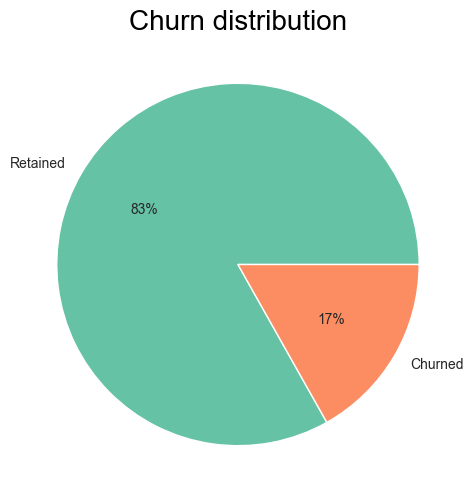

In [135]:
print('Churn count:')
print(churn_size)

labels = ['Retained', 'Churned']
colors=[ retained_col, churn_col]
with sns.axes_style("whitegrid"):
    plt.figure(figsize=(10,6), dpi=100)
    plt.pie(churn_size, labels=labels, colors=colors, autopct='%.0f%%')
    plt.title('Churn distribution', fontsize=20, color='black')
    plt.show()

In [29]:
ecommerce.groupby('Churn').mean().T

Churn,0,1
Tenure,11.502334,3.379469
CityTier,1.619821,1.827004
WarehouseToHome,15.353931,17.134259
HourSpendOnApp,2.925530,2.961798
NumberOfDeviceRegistered,3.639257,3.934599
SatisfactionScore,3.001282,3.390295
NumberOfAddress,4.162965,4.466245
Complain,0.234088,0.535865
OrderAmountHikeFromlastYear,15.724893,15.627409
CouponUsed,1.758232,1.717021


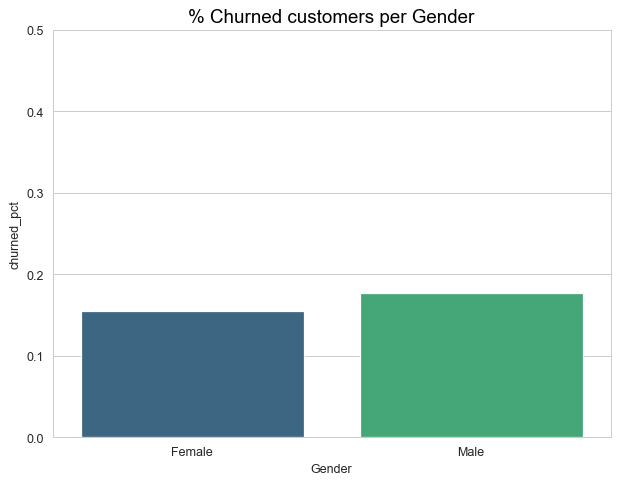

In [143]:
ecommerce['Total'] = 1

gender = pd.pivot_table(data=ecommerce, values='Total',
                       index='Gender', columns='Churn',
                       aggfunc='count')
gender['total'] = gender[1] + gender[0]
gender['churned_pct'] = gender[1] / gender['total'] 

with sns.axes_style("whitegrid"):
    plt.figure(figsize=(8,6), dpi=90)
    sns.barplot(data=gender, x=gender.index, y='churned_pct', palette='viridis')
    plt.ylim(0,0.5)
    plt.title('% Churned customers per Gender', fontsize=15, color='black')
    plt.show()

In [142]:
marital_status = pd.pivot_table(data=ecommerce, values='Total',
                               index='MaritalStatus', columns='Churn',
                               aggfunc='count')
marital_status['total'] = marital_status[1] + marital_status[0]
marital_status['churned_pct'] = marital_status[1]/marital_status['total']
marital_status['retained_pct'] = 1 - marital_status['churned_pct'] 
marital_status

Churn,0,1,total,churned_pct,retained_pct
MaritalStatus,,,,,
Married,2642,344,2986,0.115204,0.884796
Single,2040,604,2644,0.228442,0.771558


In [144]:
PreferedOrderCat = pd.pivot_table(data=ecommerce, values='Total',
                               index='PreferedOrderCat', columns='Churn',
                               aggfunc='count')
PreferedOrderCat['total'] = PreferedOrderCat[1] + PreferedOrderCat[0]
PreferedOrderCat['churned_pct'] = PreferedOrderCat[1]/PreferedOrderCat['total']
PreferedOrderCat['retained_pct'] = 1 - PreferedOrderCat['churned_pct'] 
PreferedOrderCat

Churn,0,1,total,churned_pct,retained_pct
PreferedOrderCat,,,,,
Fashion,698,128,826,0.154964,0.845036
Grocery,390,20,410,0.048780,0.951220
Laptop & Accessory,1840,210,2050,0.102439,0.897561
Mobile,589,220,809,0.271941,0.728059
Mobile Phone,921,350,1271,0.275374,0.724626
Others,244,20,264,0.075758,0.924242


% Churned customers by Preferred Login Device
PreferredLoginDevice
Computer    20.0
Phone       16.0
Name: churned_pct, dtype: float64


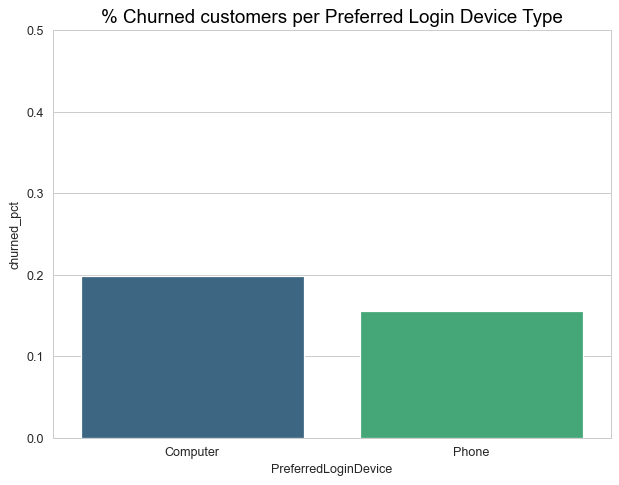

In [147]:
login_device = pd.pivot_table(data=ecommerce, values='Total',
                               index='PreferredLoginDevice', columns='Churn',
                               aggfunc='count')

login_device['total'] = login_device[1] + login_device[0]
login_device['churned_pct'] = login_device[1]/login_device['total']
login_device

print('% Churned customers by Preferred Login Device')
print(login_device['churned_pct'].round(2)*100)

with sns.axes_style("whitegrid"):
    plt.figure(figsize=(8,6), dpi=90)
    sns.barplot(data=login_device, x=login_device.index, y='churned_pct', palette='viridis' )
    plt.ylim(0,0.5)
    plt.title('% Churned customers per Preferred Login Device Type', fontsize=15, color='black')
    plt.show()

% Churned customers by Preferred Payment Method
PreferredPaymentMode
COD           24.90
E wallet      22.80
UPI           17.39
Debit Card    15.38
CC            14.21
Name: churned_pct, dtype: float64


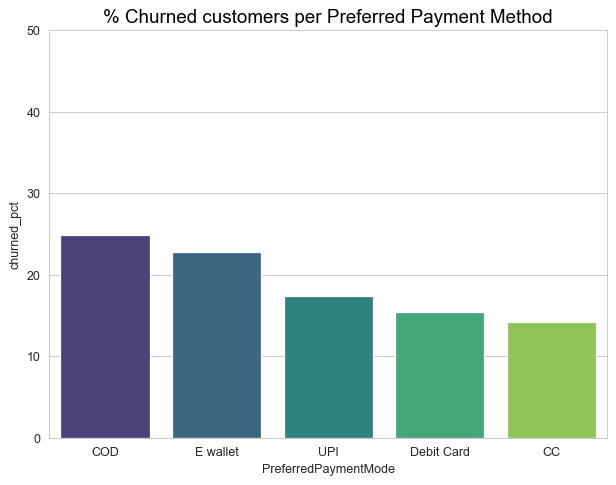

In [148]:
payment_method = pd.pivot_table(data=ecommerce, values='Total',
                               index='PreferredPaymentMode', columns='Churn',
                               aggfunc='count')

payment_method['total'] = payment_method[1] + payment_method[0]
payment_method['churned_pct'] = (payment_method[1]/payment_method['total']*100).round(2)
payment_method.sort_values(by=['churned_pct'], ascending=False, inplace=True)


print('% Churned customers by Preferred Payment Method')
print(payment_method['churned_pct'])


with sns.axes_style("whitegrid"):
    plt.figure(figsize=(8,6), dpi=90)
    sns.barplot(data=payment_method, x=payment_method.index, y='churned_pct', palette='viridis')
    plt.ylim(0,50)
    plt.title('% Churned customers per Preferred Payment Method', fontsize=15, color='black')
    plt.show()

Warehouse To Home distance:
Data were not drawn from normal dist - no ttest allowed.
---------------------------------------------------

Mean:
Churn
0    15.353931
1    17.134259
Name: WarehouseToHome, dtype: float64


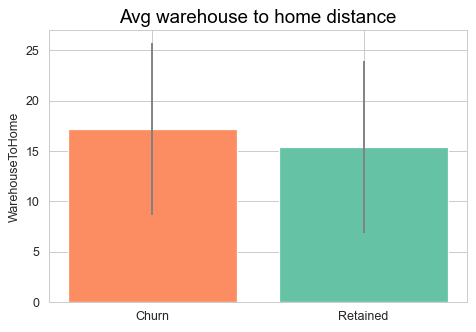

In [37]:
WTH_Ch = ecommerce[ecommerce['Churn']==1]['WarehouseToHome']
WTH_R = ecommerce[ecommerce['Churn']==0]['WarehouseToHome']


print('Warehouse To Home distance:')
result_WTH = calculate_ttest(WTH_Ch,WTH_R)
print('---------------------------------------------------\n')

print('Mean:')
print(ecommerce.groupby('Churn').mean()['WarehouseToHome'])

with sns.axes_style("whitegrid"):

    fix, ax = plt.subplots(dpi=90)
    ax.bar('Churn', churned['WarehouseToHome'].mean(), 
           yerr=ecommerce['WarehouseToHome'].std(), color=churn_col, ecolor = 'gray')  
    ax.bar('Retained', retained['WarehouseToHome'].mean(), 
           yerr=ecommerce['WarehouseToHome'].std(),  color=retained_col, ecolor = 'gray')  
    ax.set_ylabel('WarehouseToHome')
    plt.title("Avg warehouse to home distance", fontsize=15, color='black')
    plt.show()

Number Of Device Registered:
Ttest_indResult(statistic=8.145136855113543, pvalue=4.626451530290173e-16)
Ttest result is statistically significant.
---------------------------------------------------

Mean:
Churn
0    3.639257
1    3.934599
Name: NumberOfDeviceRegistered, dtype: float64


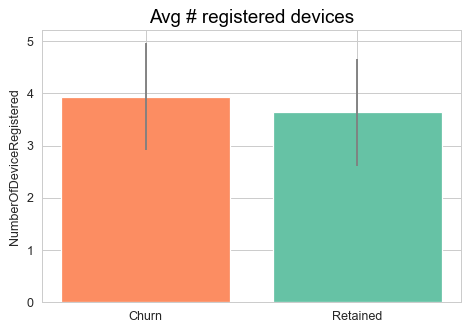

In [38]:
Dev_Ch = ecommerce[ecommerce['Churn']==1]['NumberOfDeviceRegistered']
Dev_R = ecommerce[ecommerce['Churn']==0]['NumberOfDeviceRegistered']

print('Number Of Device Registered:')
result_LastO = calculate_ttest(Dev_Ch,Dev_R)
print('---------------------------------------------------\n')

print('Mean:')
print(ecommerce.groupby('Churn').mean()['NumberOfDeviceRegistered'])

with sns.axes_style("whitegrid"):

    fix, ax = plt.subplots(dpi=90)
    ax.bar('Churn', churned['NumberOfDeviceRegistered'].mean(), 
           yerr=ecommerce['NumberOfDeviceRegistered'].std(), color=churn_col, ecolor = 'gray')  
    ax.bar('Retained', retained['NumberOfDeviceRegistered'].mean(), 
           yerr=ecommerce['NumberOfDeviceRegistered'].std(),  color=retained_col, ecolor = 'gray')  
    ax.set_ylabel('NumberOfDeviceRegistered')
    plt.title("Avg # registered devices", fontsize=15, color='black')
    plt.show()

Satisfaction Score:
Ttest_indResult(statistic=7.957588346935353, pvalue=2.105157407388599e-15)
Ttest result is statistically significant.
---------------------------------------------------

Mean:
Churn
0    3.001282
1    3.390295
Name: SatisfactionScore, dtype: float64


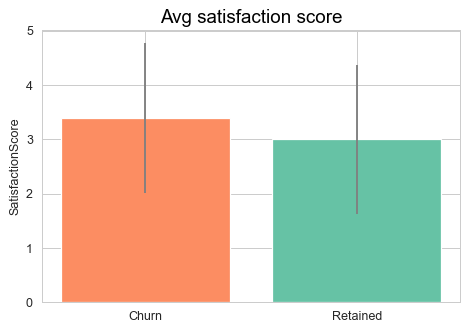

In [39]:
Sat_Ch = ecommerce[ecommerce['Churn']==1]['SatisfactionScore']
Sat_R = ecommerce[ecommerce['Churn']==0]['SatisfactionScore']

print('Satisfaction Score:')
result_Sat = calculate_ttest(Sat_Ch,Sat_R)
print('---------------------------------------------------\n')

print('Mean:')
print(ecommerce.groupby('Churn').mean()['SatisfactionScore'])

with sns.axes_style("whitegrid"):

    fix, ax = plt.subplots(dpi=90)
    ax.bar('Churn', churned['SatisfactionScore'].mean(), 
           yerr=ecommerce['SatisfactionScore'].std(), color=churn_col, ecolor = 'gray')
    ax.bar('Retained', retained['SatisfactionScore'].mean(), 
           yerr=ecommerce['SatisfactionScore'].std(), color=retained_col, ecolor = 'gray')
    ax.set_ylabel('SatisfactionScore')
    plt.title("Avg satisfaction score", fontsize=15, color='black')
    plt.show()

Customers with complaint:


Churn
0    23.0
1    54.0
Name: Complain, dtype: float64

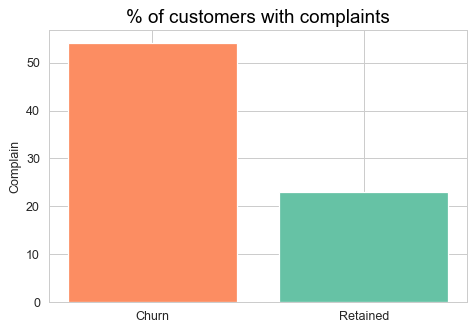

In [40]:
complain = ecommerce.groupby('Churn').sum()['Complain']
base = ecommerce.groupby('Churn').count()['Complain']

complain_pct = np.round((complain/base) * 100)
print('Customers with complaint:')
display(complain_pct)

with sns.axes_style("whitegrid"):

    fix, ax = plt.subplots(dpi=90)
    ax.bar('Churn', complain_pct[1], color=churn_col) 
    ax.bar('Retained', complain_pct[0], color=retained_col) 
    ax.set_ylabel('Complain')
    plt.title("% of customers with complaints", fontsize=15, color='black')
    plt.show()

Days Since Last Order:
Data were not drawn from normal dist - no ttest allowed.
---------------------------------------------------

Mean:
Churn
0    4.807406
1    3.236018
Name: DaySinceLastOrder, dtype: float64


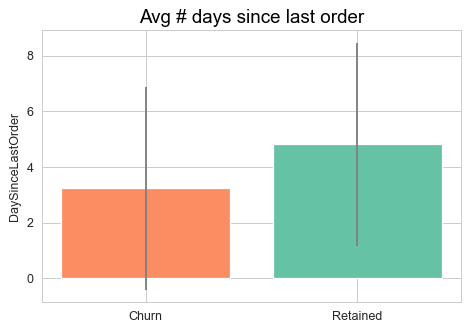

In [41]:
LastO_Ch = ecommerce[ecommerce['Churn']==1]['DaySinceLastOrder']
LastO_R = ecommerce[ecommerce['Churn']==0]['DaySinceLastOrder']

print('Days Since Last Order:')
result_LastO = calculate_ttest(LastO_Ch,LastO_R)
print('---------------------------------------------------\n')

print('Mean:')
print(ecommerce.groupby('Churn').mean()['DaySinceLastOrder'])

with sns.axes_style("whitegrid"):

    fix, ax = plt.subplots(dpi=90)
    ax.bar('Churn', churned['DaySinceLastOrder'].mean(), 
           yerr=ecommerce['DaySinceLastOrder'].std(), color=churn_col, ecolor = 'gray')  
    ax.bar('Retained', retained['DaySinceLastOrder'].mean(), 
           yerr=ecommerce['DaySinceLastOrder'].std(), color=retained_col, ecolor = 'gray')  
    ax.set_ylabel('DaySinceLastOrder')
    plt.title("Avg # days since last order", fontsize=15, color='black')
    plt.show()

Tenure:
Data were not drawn from normal dist - no ttest allowed.
---------------------------------------------------

Mean:
Churn
0    11.502334
1     3.379469
Name: Tenure, dtype: float64


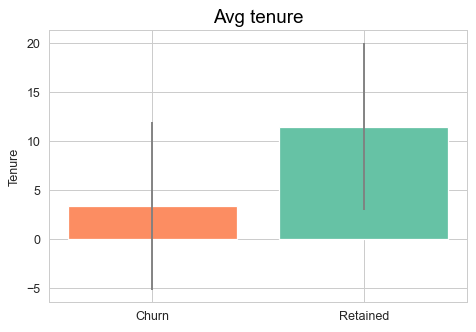

In [42]:
Tenure_Ch = ecommerce[ecommerce['Churn']==1]['Tenure']
Tenure_R = ecommerce[ecommerce['Churn']==0]['Tenure']

print('Tenure:')
result_Tenure = calculate_ttest(Tenure_Ch,Tenure_R)
print('---------------------------------------------------\n')

print('Mean:')
print(ecommerce.groupby('Churn').mean()['Tenure'])

with sns.axes_style("whitegrid"):

    fix, ax = plt.subplots(dpi=90)
    ax.bar('Churn', churned['Tenure'].mean(), 
           yerr=ecommerce['Tenure'].std(), color=churn_col, ecolor = 'gray')
    ax.bar('Retained', retained['Tenure'].mean(), 
           yerr=ecommerce['Tenure'].std(), color=retained_col, ecolor = 'gray')
    ax.set_ylabel('Tenure')
    plt.title("Avg tenure", fontsize=15, color='black')
    plt.show()
    

Cashback Amount:
Ttest_indResult(statistic=-11.705098814654978, pvalue=2.759427684642311e-31)
Ttest result is statistically significant.
---------------------------------------------------

Mean:
Churn
0    180.633704
1    160.369198
Name: CashbackAmount, dtype: float64


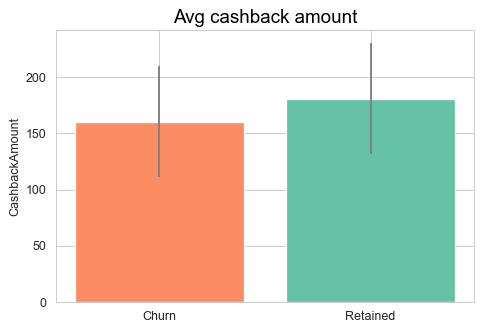

In [43]:
Cahsback_Ch = ecommerce[ecommerce['Churn']==1]['CashbackAmount']
Cashback_R = ecommerce[ecommerce['Churn']==0]['CashbackAmount']

print('Cashback Amount:')
result_Cashback = calculate_ttest(Cahsback_Ch,Cashback_R)
print('---------------------------------------------------\n')


print('Mean:')
print(ecommerce.groupby('Churn').mean()['CashbackAmount'])


with sns.axes_style("whitegrid"):

    fix, ax = plt.subplots(dpi=90)
    ax.bar('Churn', churned['CashbackAmount'].mean(), 
           yerr=ecommerce['CashbackAmount'].std(), color=churn_col, ecolor = 'gray')
    ax.bar('Retained', retained['CashbackAmount'].mean(), 
           yerr=ecommerce['CashbackAmount'].std(), color=retained_col, ecolor = 'gray')
    ax.set_ylabel('CashbackAmount')
    plt.title("Avg cashback amount", fontsize=15, color='black')
    plt.show()

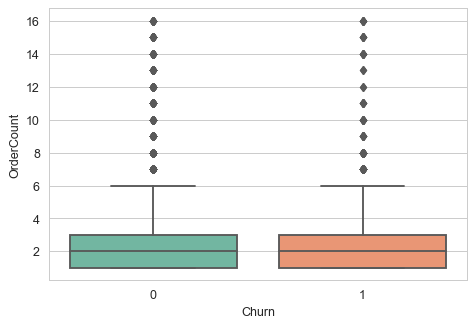

In [44]:
my_pal = {1:churn_col, 0:retained_col}
with sns.axes_style("whitegrid"):

    fix, ax = plt.subplots(dpi=90)
    sns.boxplot(x='Churn', y='OrderCount', data=ecommerce, palette=my_pal)
    plt.show()

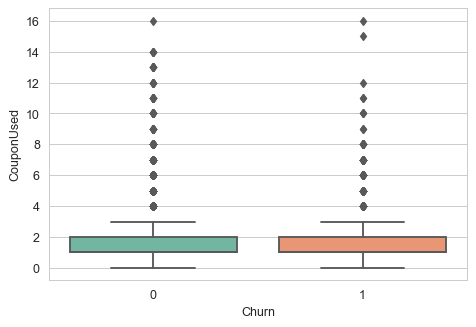

In [45]:
with sns.axes_style("whitegrid"):

    fix, ax = plt.subplots(dpi=90)
    sns.boxplot(x='Churn', y='CouponUsed', data=ecommerce, palette=my_pal)
    plt.show()

## Train_Test_split

In [46]:
X_columns = ['CityTier', 'Tenure', 'DaySinceLastOrder', 'CashbackAmount','OrderCount', 'CouponUsed', 
            'WarehouseToHome','SatisfactionScore', 'NumberOfAddress','NumberOfDeviceRegistered', 'Complain', 
            'PreferredLoginDevice','PreferredPaymentMode', 'PreferedOrderCat','Gender', 'MaritalStatus', 'Churn']

X = ecommerce[X_columns]


X_train, X_test = train_test_split(X,
                                  test_size=0.2,
                                  shuffle=True,
                                  random_state=42,
                                  stratify=X['Churn'])

In [47]:
print(f'X_train size: {X_train.shape}')
print(f'X_test size: {X_test.shape}')

X_train size: (4504, 17)
X_test size: (1126, 17)


## Target variable

In [48]:
y_train = X_train.pop('Churn')
y_test = X_test.pop('Churn')

In [49]:
print(f'y_train size: {y_train.shape}')
print(f'y_test size: {y_test.shape}')

y_train size: (4504,)
y_test size: (1126,)


## Feature engineering

In [50]:
num_attr = X_train.select_dtypes(include='number').columns
cat_attr = X_train.select_dtypes(exclude='number').columns

In [51]:
num_pipeline = Pipeline(
    [
      ('imputer', SimpleImputer(strategy='median')),
      ('scaler', StandardScaler())
    ]
)

cat_pipeline = Pipeline(
    [
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('ohe', OneHotEncoder(sparse=False))
    ]
)

cat_num_pipeline = ColumnTransformer(
    [
        ('numerical', num_pipeline, num_attr),
        ('categorical', cat_pipeline, cat_attr)
    ]
)

In [52]:
cat_num_pipeline

ColumnTransformer(transformers=[('numerical',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 Index(['CityTier', 'Tenure', 'DaySinceLastOrder', 'CashbackAmount',
       'OrderCount', 'CouponUsed', 'WarehouseToHome', 'SatisfactionScore',
       'NumberOfAddress', 'NumberOfDeviceRegistered', 'Complain'],
      dtype='object')),
                                ('categorical',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(sparse=False))]),
                                 Index(['PreferredLoginDevice', 'PreferredPaymentMode', 'PreferedOrderCat',
       'Gender', 'MaritalStatus'],
      dtype='object'))])

### Modeling

#### Logistic Regression

In [53]:
lg_param_grid = [
    {
        'cat_num_pipeline__numerical__imputer__strategy': ['mean', 'median'],
        'cat_num_pipeline__categorical__ohe__drop': [None, 'first'],
        'model__C': [0.1, 0.5, 1, 1.5]
    }
]

In [54]:
lg_model = Pipeline(
    [
        ('cat_num_pipeline', cat_num_pipeline),
        ('model', LogisticRegression())
    ]
)

In [55]:
lg_grid_search = GridSearchCV(lg_model, lg_param_grid, verbose=3, scoring='f1')
lg_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END cat_num_pipeline__categorical__ohe__drop=None, cat_num_pipeline__numerical__imputer__strategy=mean, model__C=0.1;, score=0.622 total time=   0.0s
[CV 2/5] END cat_num_pipeline__categorical__ohe__drop=None, cat_num_pipeline__numerical__imputer__strategy=mean, model__C=0.1;, score=0.590 total time=   0.0s
[CV 3/5] END cat_num_pipeline__categorical__ohe__drop=None, cat_num_pipeline__numerical__imputer__strategy=mean, model__C=0.1;, score=0.602 total time=   0.0s
[CV 4/5] END cat_num_pipeline__categorical__ohe__drop=None, cat_num_pipeline__numerical__imputer__strategy=mean, model__C=0.1;, score=0.616 total time=   0.0s
[CV 5/5] END cat_num_pipeline__categorical__ohe__drop=None, cat_num_pipeline__numerical__imputer__strategy=mean, model__C=0.1;, score=0.580 total time=   0.0s
[CV 1/5] END cat_num_pipeline__categorical__ohe__drop=None, cat_num_pipeline__numerical__imputer__strategy=mean, model__C=0.5;, score=0.620 tota

[CV 5/5] END cat_num_pipeline__categorical__ohe__drop=first, cat_num_pipeline__numerical__imputer__strategy=mean, model__C=1;, score=0.605 total time=   0.0s
[CV 1/5] END cat_num_pipeline__categorical__ohe__drop=first, cat_num_pipeline__numerical__imputer__strategy=mean, model__C=1.5;, score=0.623 total time=   0.0s
[CV 2/5] END cat_num_pipeline__categorical__ohe__drop=first, cat_num_pipeline__numerical__imputer__strategy=mean, model__C=1.5;, score=0.598 total time=   0.0s
[CV 3/5] END cat_num_pipeline__categorical__ohe__drop=first, cat_num_pipeline__numerical__imputer__strategy=mean, model__C=1.5;, score=0.618 total time=   0.0s
[CV 4/5] END cat_num_pipeline__categorical__ohe__drop=first, cat_num_pipeline__numerical__imputer__strategy=mean, model__C=1.5;, score=0.625 total time=   0.0s
[CV 5/5] END cat_num_pipeline__categorical__ohe__drop=first, cat_num_pipeline__numerical__imputer__strategy=mean, model__C=1.5;, score=0.610 total time=   0.0s
[CV 1/5] END cat_num_pipeline__categorical

GridSearchCV(estimator=Pipeline(steps=[('cat_num_pipeline',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['CityTier', 'Tenure', 'DaySinceLastOrder', 'CashbackAmount',
       'OrderCount', 'CouponUsed', 'WarehouseToHome', 'SatisfactionScore',
       'NumberOfAddress', 'NumberOf...
                                                                                          OneHotEncoder(sparse=False))]),
                                                                         Index(['PreferredLoginDevice', 'PreferredPaymentMode', 'PreferedOrderCat',
       'Gender', 'MaritalStatus'],
      dtype='object'))])),
                                       ('model', LogisticRegression())]),
             param_grid=[{'cat_num_pipeline__categorical__ohe__drop': [None,
                                                                       'first'],
                          'cat_num_pipeline__numerical__imputer__strategy': ['mean',
                                                                             'median'],
                          'model__C': [0.1, 0.5, 1, 1.5]}],
             scoring='f1', verbose=3)

In [56]:
lg_grid_search_results = pd.DataFrame(lg_grid_search.cv_results_)
lg_grid_search_results.sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_cat_num_pipeline__categorical__ohe__drop,param_cat_num_pipeline__numerical__imputer__strategy,param_model__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
14,0.060273,0.002736,0.009392,0.001186,first,median,1,{'cat_num_pipeline__categorical__ohe__drop': '...,0.625483,0.595420,0.626016,0.627907,0.609375,0.616840,0.012617,1
15,0.056605,0.004307,0.008362,0.000378,first,median,1.5,{'cat_num_pipeline__categorical__ohe__drop': '...,0.625954,0.593156,0.617886,0.627907,0.612403,0.615461,0.012472,2
6,0.068101,0.004553,0.008073,0.000534,None,median,1,{'cat_num_pipeline__categorical__ohe__drop': N...,0.623077,0.595420,0.620408,0.627907,0.609375,0.615237,0.011626,3
11,0.059965,0.003661,0.008606,0.000833,first,mean,1.5,{'cat_num_pipeline__categorical__ohe__drop': '...,0.623077,0.597701,0.617886,0.625000,0.610039,0.614741,0.009971,4
13,0.057650,0.003180,0.008810,0.000732,first,median,0.5,{'cat_num_pipeline__categorical__ohe__drop': '...,0.627907,0.596899,0.617284,0.627907,0.600791,0.614158,0.013148,5
7,0.070202,0.003595,0.008942,0.000877,None,median,1.5,{'cat_num_pipeline__categorical__ohe__drop': N...,0.615970,0.590909,0.617886,0.627907,0.612403,0.613015,0.012192,6
3,0.074572,0.005617,0.009459,0.001493,None,mean,1.5,{'cat_num_pipeline__categorical__ohe__drop': N...,0.618321,0.597701,0.612245,0.625000,0.607692,0.612192,0.009293,7
10,0.061406,0.007376,0.009144,0.000711,first,mean,1,{'cat_num_pipeline__categorical__ohe__drop': '...,0.614786,0.596899,0.617886,0.619608,0.604651,0.610766,0.008657,8
9,0.054714,0.003051,0.008165,0.001005,first,mean,0.5,{'cat_num_pipeline__categorical__ohe__drop': '...,0.625483,0.594595,0.617284,0.617187,0.596078,0.610125,0.012454,9
2,0.072699,0.009970,0.009622,0.000968,None,mean,1,{'cat_num_pipeline__categorical__ohe__drop': N...,0.614786,0.602317,0.606557,0.619608,0.604651,0.609584,0.006540,10


In [57]:
drop_gs = lg_grid_search.best_params_['cat_num_pipeline__categorical__ohe__drop']
strategy_gs = lg_grid_search.best_params_['cat_num_pipeline__numerical__imputer__strategy']
modelC_gs = lg_grid_search.best_params_['model__C']
modelC_gs

1

In [58]:
num_pipeline_fin = Pipeline(
    [
      ('imputer', SimpleImputer(strategy=strategy_gs)),
      ('scaler', StandardScaler())
    ]
)

cat_pipeline_fin = Pipeline(
    [
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('ohe', OneHotEncoder(sparse=False, drop=drop_gs))
    ]
)

cat_num_pipeline_fin = ColumnTransformer(
    [
        ('numerical', num_pipeline_fin, num_attr),
        ('categorical', cat_pipeline_fin, cat_attr)
    ]
)

cat_num_pipeline_fin

ColumnTransformer(transformers=[('numerical',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 Index(['CityTier', 'Tenure', 'DaySinceLastOrder', 'CashbackAmount',
       'OrderCount', 'CouponUsed', 'WarehouseToHome', 'SatisfactionScore',
       'NumberOfAddress', 'NumberOfDeviceRegistered', 'Complain'],
      dtype='object')),
                                ('categorical',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False))]),
                                 Index(['PreferredLoginDevice', 'PreferredPaymentMode', 'PreferedOrderCat',
       'Gender', 'MaritalStatus'],
      dtype='object'))])

In [60]:
lg_model_best_model = Pipeline(
    [
        ('cat_num_pipeline', cat_num_pipeline_fin),
        ('model', LogisticRegression(C=modelC_gs))
    ]
)

lg_model_best_model.fit(X_train, y_train)

Pipeline(steps=[('cat_num_pipeline',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['CityTier', 'Tenure', 'DaySinceLastOrder', 'CashbackAmount',
       'OrderCount', 'CouponUsed', 'WarehouseToHome', 'SatisfactionScore',
       'NumberOfAddress', 'NumberOfDeviceRegistered', 'Complain'],
      dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  Index(['PreferredLoginDevice', 'PreferredPaymentMode', 'PreferedOrderCat',
       'Gender', 'MaritalStatus'],
      dtype='object'))])),
                ('model', LogisticRegression(C=1))])

In [67]:
y_score_lg_full = lg_model_best_model.predict_proba(X_test)
y_pred_lg_tr = lg_model_best_model.predict(X_train)
y_pred_lg = lg_model_best_model.predict(X_test)

In [77]:
results = pd.DataFrame({'probability': y_score_lg,
            'y_test':y_test,
            'y_pred':y_pred_lg,
            'Tenure': X_test['Tenure'],
            'DaySinceLastOrder': X_test['DaySinceLastOrder'],
            'CashbackAmount': X_test['CashbackAmount'],
            'OrderCount': X_test['OrderCount'],
            'CouponUsed': X_test['CouponUsed'],
            'WarehouseToHome': X_test['WarehouseToHome'],
            'SatisfactionScore': X_test['SatisfactionScore'],   
            'Complain': X_test['Complain'], 
            'PreferredPaymentMode': X_test['PreferredPaymentMode'],
            'PreferedOrderCat': X_test['PreferedOrderCat'],   
            'Gender': X_test['Gender'],   
            'MaritalStatus': X_test['MaritalStatus']})
                        
                        
                        
results[y_test != y_pred_lg]

,probability,y_test,y_pred,Tenure,DaySinceLastOrder,CashbackAmount,OrderCount,CouponUsed,WarehouseToHome,SatisfactionScore,Complain,PreferredPaymentMode,PreferedOrderCat,Gender,MaritalStatus
2295,0.543326,0,1,4.0,6.0,199,9.0,8.0,8.0,3,1,Debit Card,Fashion,Female,Married
958,0.214150,1,0,NaN,0.0,120,1.0,1.0,15.0,5,0,Debit Card,Mobile,Male,Single
5216,0.490159,1,0,1.0,3.0,154,2.0,2.0,8.0,3,0,COD,Mobile Phone,Male,Married
4377,0.179562,1,0,1.0,6.0,146,2.0,1.0,7.0,3,0,COD,Mobile Phone,Male,Single
1841,0.643730,0,1,0.0,2.0,134,1.0,0.0,28.0,3,0,COD,Mobile,Male,Single
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3446,0.653816,0,1,6.0,8.0,165,8.0,6.0,36.0,3,0,CC,Mobile Phone,Female,Single
4365,0.164855,1,0,1.0,10.0,201,2.0,1.0,34.0,1,0,E wallet,Fashion,Female,Married
2186,0.722322,0,1,0.0,2.0,136,1.0,0.0,30.0,4,0,CC,Mobile Phone,Male,Single
3936,0.396402,1,0,1.0,3.0,147,2.0,2.0,15.0,1,0,UPI,Mobile Phone,Female,Married


TRAIN dataset
TEST dataset


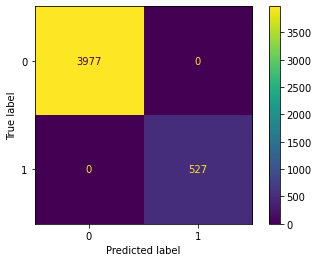

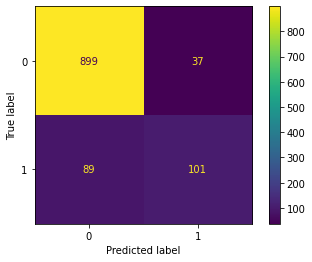

In [78]:
print('TRAIN dataset')
print(ConfusionMatrixDisplay.from_estimator(lg_model_best_model, X_train, y_pred_lg_tr))
print('TEST dataset')
ConfusionMatrixDisplay.from_estimator(lg_model_best_model, X_test, y_test)

In [79]:
print('Logistic Regresion - best model: ')
print('--------------------------------------------')
print('Train dataset: ')
print('Classification report')
print(classification_report(y_train, y_pred_lg_tr))
print('----------------')
print(f'Accuracy: {accuracy_score(y_train, y_pred_lg_tr)}')
print(f'How many relevant cases are found? {recall_score(y_train, y_pred_lg_tr)}')
print(f'When prediction is positive, how often is it correct? {precision_score(y_train, y_pred_lg_tr)}')

print('--------------------------------------------')
print('Test dataset: ')
print('Classification report')
print(classification_report(y_test, y_pred_lg))
print('----------------')
print(f'Accuracy: {accuracy_score(y_test, y_pred_lg)}')
print(f'How many relevant cases are found? {recall_score(y_test, y_pred_lg)}')
print(f'When prediction is positive, how often is it correct? {precision_score(y_test, y_pred_lg)}')

Logistic Regresion - best model: 
--------------------------------------------
Train dataset: 
Classification report
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      3746
           1       0.77      0.54      0.63       758

    accuracy                           0.90      4504
   macro avg       0.84      0.75      0.79      4504
weighted avg       0.89      0.90      0.89      4504

----------------
Accuracy: 0.8954262877442274
How many relevant cases are found? 0.5369393139841688
When prediction is positive, how often is it correct? 0.7722960151802657
--------------------------------------------
Test dataset: 
Classification report
              precision    recall  f1-score   support

           0       0.91      0.96      0.93       936
           1       0.73      0.53      0.62       190

    accuracy                           0.89      1126
   macro avg       0.82      0.75      0.78      1126
weighted avg       0.88      

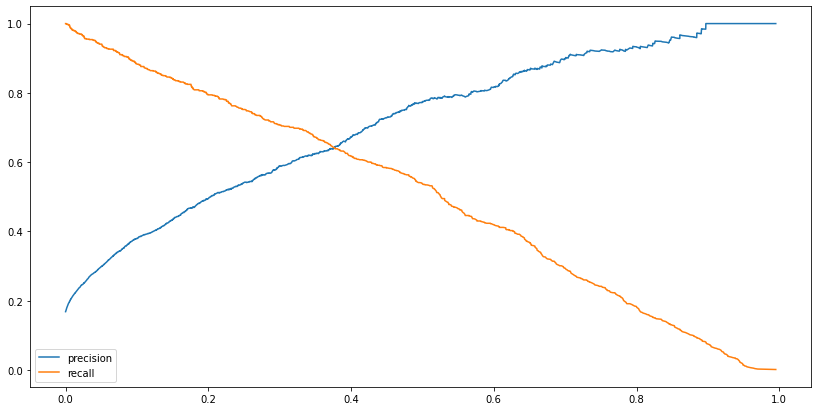

In [80]:
show_precision_recall(lg_model_best_model, X_train, y_train)

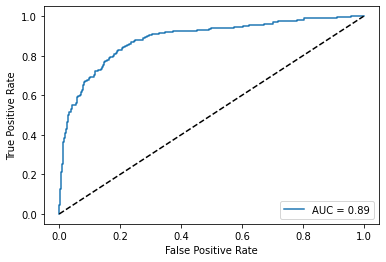

In [81]:
y_score_lg = lg_model_best_model.predict_proba(X_test)[:, 1]
fpr, tpr, thr = roc_curve(y_test, y_score_lg) 
roc_auc = auc(fpr, tpr) 

RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()
plt.plot([0,1], [0,1], 'k--')
plt.show()

In [82]:
f_names  = lg_model_best_model[:-1].get_feature_names_out()
coefs = pd.Series(index=f_names, data = lg_model_best_model['model'].coef_[0]).sort_values()

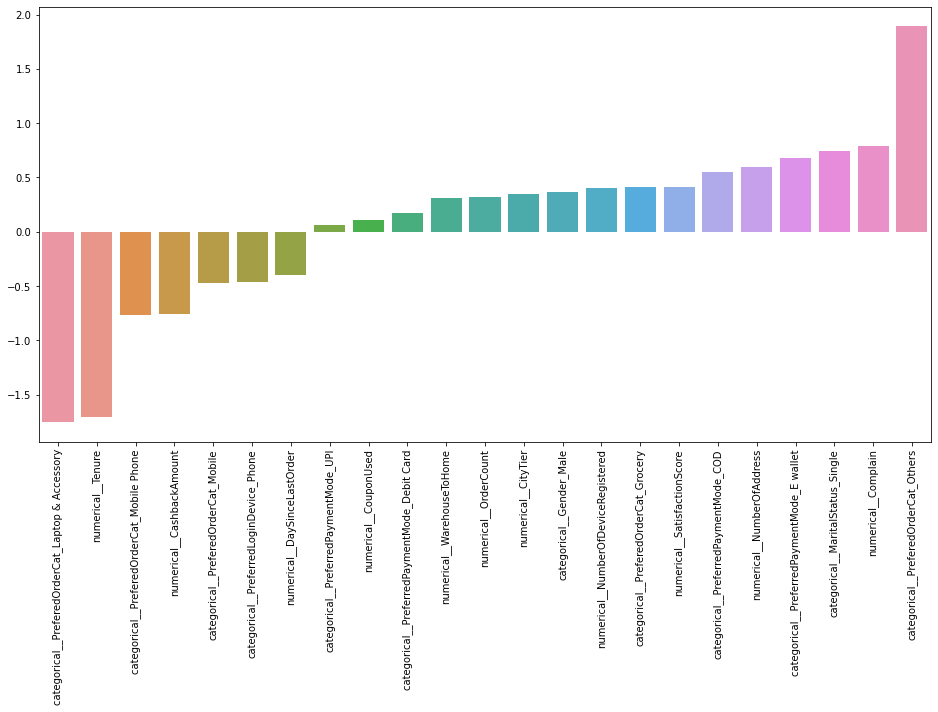

In [83]:
plt.figure(figsize=(16,8))
sns.barplot(x=coefs.index, y=coefs.values)
plt.xticks(rotation=90)
plt.show()

In [84]:
filename = 'finalized_model_logreg.sav'
joblib.dump(lg_model_best_model, filename)

['finalized_model_logreg.sav']

#### SVM

In [85]:
svc_param_grid = [
    {
        "svc__kernel": ['linear', 'rbf', 'poly', 'sigmoid'],
        "svc__C": np.arange(0.1,3,0.1) 
    }
]

In [86]:
svc_model = Pipeline(
    [
        ('cat_num_pipeline', cat_num_pipeline),
        ('svc', SVC(probability=True, class_weight='balanced')) 
    ]
)

In [87]:
svc_grid_search = GridSearchCV(svc_model, svc_param_grid, verbose=3, scoring="f1")
svc_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 116 candidates, totalling 580 fits
[CV 1/5] END ....svc__C=0.1, svc__kernel=linear;, score=0.580 total time=   2.1s
[CV 2/5] END ....svc__C=0.1, svc__kernel=linear;, score=0.566 total time=   2.1s
[CV 3/5] END ....svc__C=0.1, svc__kernel=linear;, score=0.609 total time=   2.0s
[CV 4/5] END ....svc__C=0.1, svc__kernel=linear;, score=0.581 total time=   1.9s
[CV 5/5] END ....svc__C=0.1, svc__kernel=linear;, score=0.597 total time=   1.9s
[CV 1/5] END .......svc__C=0.1, svc__kernel=rbf;, score=0.625 total time=   3.9s
[CV 2/5] END .......svc__C=0.1, svc__kernel=rbf;, score=0.590 total time=   4.3s
[CV 3/5] END .......svc__C=0.1, svc__kernel=rbf;, score=0.658 total time=   4.3s
[CV 4/5] END .......svc__C=0.1, svc__kernel=rbf;, score=0.599 total time=   4.0s
[CV 5/5] END .......svc__C=0.1, svc__kernel=rbf;, score=0.615 total time=   4.0s
[CV 1/5] END ......svc__C=0.1, svc__kernel=poly;, score=0.654 total time=   2.9s
[CV 2/5] END ......svc__C=0.1, svc__kernel=pol

[CV 4/5] END ...svc__C=0.5, svc__kernel=sigmoid;, score=0.460 total time=   2.3s
[CV 5/5] END ...svc__C=0.5, svc__kernel=sigmoid;, score=0.490 total time=   2.5s
[CV 1/5] END ....svc__C=0.6, svc__kernel=linear;, score=0.586 total time=   2.7s
[CV 2/5] END ....svc__C=0.6, svc__kernel=linear;, score=0.558 total time=   2.6s
[CV 3/5] END ....svc__C=0.6, svc__kernel=linear;, score=0.612 total time=   2.6s
[CV 4/5] END ....svc__C=0.6, svc__kernel=linear;, score=0.578 total time=   2.5s
[CV 5/5] END ....svc__C=0.6, svc__kernel=linear;, score=0.593 total time=   2.7s
[CV 1/5] END .......svc__C=0.6, svc__kernel=rbf;, score=0.718 total time=   3.2s
[CV 2/5] END .......svc__C=0.6, svc__kernel=rbf;, score=0.653 total time=   3.3s
[CV 3/5] END .......svc__C=0.6, svc__kernel=rbf;, score=0.743 total time=   3.2s
[CV 4/5] END .......svc__C=0.6, svc__kernel=rbf;, score=0.661 total time=   3.0s
[CV 5/5] END .......svc__C=0.6, svc__kernel=rbf;, score=0.690 total time=   3.1s
[CV 1/5] END ......svc__C=0.

[CV 3/5] END ...svc__C=1.0, svc__kernel=sigmoid;, score=0.501 total time=   2.1s
[CV 4/5] END ...svc__C=1.0, svc__kernel=sigmoid;, score=0.458 total time=   1.9s
[CV 5/5] END ...svc__C=1.0, svc__kernel=sigmoid;, score=0.488 total time=   2.0s
[CV 1/5] END ....svc__C=1.1, svc__kernel=linear;, score=0.586 total time=   3.3s
[CV 2/5] END ....svc__C=1.1, svc__kernel=linear;, score=0.562 total time=   3.2s
[CV 3/5] END ....svc__C=1.1, svc__kernel=linear;, score=0.610 total time=   3.4s
[CV 4/5] END ....svc__C=1.1, svc__kernel=linear;, score=0.578 total time=   3.3s
[CV 5/5] END ....svc__C=1.1, svc__kernel=linear;, score=0.594 total time=   3.0s
[CV 1/5] END .......svc__C=1.1, svc__kernel=rbf;, score=0.739 total time=   2.9s
[CV 2/5] END .......svc__C=1.1, svc__kernel=rbf;, score=0.686 total time=   2.9s
[CV 3/5] END .......svc__C=1.1, svc__kernel=rbf;, score=0.772 total time=   2.9s
[CV 4/5] END .......svc__C=1.1, svc__kernel=rbf;, score=0.704 total time=   2.9s
[CV 5/5] END .......svc__C=1

[CV 1/5] END svc__C=1.5000000000000002, svc__kernel=poly;, score=0.780 total time=   2.0s
[CV 2/5] END svc__C=1.5000000000000002, svc__kernel=poly;, score=0.761 total time=   2.3s
[CV 3/5] END svc__C=1.5000000000000002, svc__kernel=poly;, score=0.796 total time=   2.3s
[CV 4/5] END svc__C=1.5000000000000002, svc__kernel=poly;, score=0.742 total time=   2.0s
[CV 5/5] END svc__C=1.5000000000000002, svc__kernel=poly;, score=0.785 total time=   1.8s
[CV 1/5] END svc__C=1.5000000000000002, svc__kernel=sigmoid;, score=0.451 total time=   1.9s
[CV 2/5] END svc__C=1.5000000000000002, svc__kernel=sigmoid;, score=0.420 total time=   2.0s
[CV 3/5] END svc__C=1.5000000000000002, svc__kernel=sigmoid;, score=0.497 total time=   2.2s
[CV 4/5] END svc__C=1.5000000000000002, svc__kernel=sigmoid;, score=0.449 total time=   2.1s
[CV 5/5] END svc__C=1.5000000000000002, svc__kernel=sigmoid;, score=0.456 total time=   2.0s
[CV 1/5] END ....svc__C=1.6, svc__kernel=linear;, score=0.586 total time=   4.2s
[CV 

[CV 4/5] END ....svc__C=2.0, svc__kernel=linear;, score=0.581 total time=   3.7s
[CV 5/5] END ....svc__C=2.0, svc__kernel=linear;, score=0.593 total time=   3.9s
[CV 1/5] END .......svc__C=2.0, svc__kernel=rbf;, score=0.772 total time=   2.9s
[CV 2/5] END .......svc__C=2.0, svc__kernel=rbf;, score=0.749 total time=   2.8s
[CV 3/5] END .......svc__C=2.0, svc__kernel=rbf;, score=0.808 total time=   2.7s
[CV 4/5] END .......svc__C=2.0, svc__kernel=rbf;, score=0.749 total time=   2.6s
[CV 5/5] END .......svc__C=2.0, svc__kernel=rbf;, score=0.776 total time=   2.6s
[CV 1/5] END ......svc__C=2.0, svc__kernel=poly;, score=0.781 total time=   1.9s
[CV 2/5] END ......svc__C=2.0, svc__kernel=poly;, score=0.773 total time=   1.7s
[CV 3/5] END ......svc__C=2.0, svc__kernel=poly;, score=0.793 total time=   2.3s
[CV 4/5] END ......svc__C=2.0, svc__kernel=poly;, score=0.760 total time=   1.8s
[CV 5/5] END ......svc__C=2.0, svc__kernel=poly;, score=0.788 total time=   1.7s
[CV 1/5] END ...svc__C=2.0, 

[CV 1/5] END svc__C=2.5000000000000004, svc__kernel=linear;, score=0.586 total time=   4.0s
[CV 2/5] END svc__C=2.5000000000000004, svc__kernel=linear;, score=0.563 total time=   4.1s
[CV 3/5] END svc__C=2.5000000000000004, svc__kernel=linear;, score=0.613 total time=   4.2s
[CV 4/5] END svc__C=2.5000000000000004, svc__kernel=linear;, score=0.578 total time=   3.9s
[CV 5/5] END svc__C=2.5000000000000004, svc__kernel=linear;, score=0.600 total time=   3.9s
[CV 1/5] END svc__C=2.5000000000000004, svc__kernel=rbf;, score=0.777 total time=   2.3s
[CV 2/5] END svc__C=2.5000000000000004, svc__kernel=rbf;, score=0.759 total time=   2.4s
[CV 3/5] END svc__C=2.5000000000000004, svc__kernel=rbf;, score=0.807 total time=   2.5s
[CV 4/5] END svc__C=2.5000000000000004, svc__kernel=rbf;, score=0.772 total time=   2.3s
[CV 5/5] END svc__C=2.5000000000000004, svc__kernel=rbf;, score=0.794 total time=   2.3s
[CV 1/5] END svc__C=2.5000000000000004, svc__kernel=poly;, score=0.781 total time=   1.6s
[CV 2

[CV 1/5] END svc__C=2.9000000000000004, svc__kernel=sigmoid;, score=0.449 total time=   1.5s
[CV 2/5] END svc__C=2.9000000000000004, svc__kernel=sigmoid;, score=0.423 total time=   1.4s
[CV 3/5] END svc__C=2.9000000000000004, svc__kernel=sigmoid;, score=0.478 total time=   1.6s
[CV 4/5] END svc__C=2.9000000000000004, svc__kernel=sigmoid;, score=0.450 total time=   1.6s
[CV 5/5] END svc__C=2.9000000000000004, svc__kernel=sigmoid;, score=0.463 total time=   1.5s


GridSearchCV(estimator=Pipeline(steps=[('cat_num_pipeline',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['CityTier', 'Tenure', 'DaySinceLastOrder', 'CashbackAmount',
       'OrderCount', 'CouponUsed', 'WarehouseToHome', 'SatisfactionScore',
       'NumberOfAddress', 'NumberOf...
                                                                         Index(['PreferredLoginDevice', 'PreferredPaymentMode', 'PreferedOrderCat',
       'Gender', 'MaritalStatus'],
      dtype='object'))])),
                                       ('svc',
                                        SVC(class_weight='balanced',
                                            probability=True))]),
             param_grid=[{'svc__C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9]),
                          'svc__kernel': ['linear', 'rbf', 'poly', 'sigmoid']}],
             scoring='f1', verbose=3)

In [88]:
grid_search_svc_results = pd.DataFrame(svc_grid_search.cv_results_)
grid_search_svc_results.sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svc__C,param_svc__kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
113,2.280636,0.077648,0.160988,0.008056,2.9,rbf,"{'svc__C': 2.9000000000000004, 'svc__kernel': ...",0.791908,0.776204,0.820669,0.789474,0.803571,0.796365,0.014943,1
109,2.239747,0.082783,0.165314,0.007851,2.8,rbf,"{'svc__C': 2.8000000000000003, 'svc__kernel': ...",0.786127,0.764873,0.823171,0.785924,0.800000,0.792019,0.019199,2
105,2.337189,0.049641,0.168497,0.006745,2.7,rbf,"{'svc__C': 2.7, 'svc__kernel': 'rbf'}",0.783862,0.764873,0.823171,0.782353,0.797619,0.790375,0.019417,3
110,1.693654,0.059401,0.051036,0.002514,2.8,poly,"{'svc__C': 2.8000000000000003, 'svc__kernel': ...",0.782857,0.782857,0.814590,0.767908,0.786982,0.787039,0.015232,4
101,2.409921,0.049445,0.170447,0.011818,2.6,rbf,"{'svc__C': 2.6, 'svc__kernel': 'rbf'}",0.783862,0.759207,0.812121,0.780059,0.797619,0.786573,0.017739,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,2.405419,0.401079,0.084963,0.011828,2.2,sigmoid,"{'svc__C': 2.2, 'svc__kernel': 'sigmoid'}",0.444898,0.422311,0.486842,0.442623,0.455142,0.450363,0.021120,112
67,1.901438,0.121985,0.075935,0.005211,1.7,sigmoid,"{'svc__C': 1.7000000000000002, 'svc__kernel': ...",0.444444,0.419552,0.494432,0.440748,0.452489,0.450333,0.024590,113
71,1.880479,0.063726,0.077726,0.008242,1.8,sigmoid,"{'svc__C': 1.8000000000000003, 'svc__kernel': ...",0.445361,0.416162,0.493392,0.439425,0.446953,0.448258,0.025121,114
91,1.911815,0.189151,0.081251,0.020448,2.3,sigmoid,"{'svc__C': 2.3000000000000003, 'svc__kernel': ...",0.445344,0.423154,0.488987,0.438017,0.441913,0.447483,0.022089,115


In [89]:
svc_C = svc_grid_search.best_params_['svc__C']
svc_kernel = svc_grid_search.best_params_['svc__kernel']

In [91]:
svc_model_best = Pipeline(
    [
        ('cat_num_pipeline', cat_num_pipeline),
        ('svc', SVC(kernel=svc_kernel, C=svc_C,  probability=True, class_weight='balanced')) 
    ]
)

In [92]:
svc_model_best.fit(X_train, y_train)

Pipeline(steps=[('cat_num_pipeline',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['CityTier', 'Tenure', 'DaySinceLastOrder', 'CashbackAmount',
       'OrderCount', 'CouponUsed', 'WarehouseToHome', 'SatisfactionScore',
       'NumberOfAddress', 'NumberOfDeviceRegistered', 'Complain'],
      dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(sparse=False))]),
                                                  Index(['PreferredLoginDevice', 'PreferredPaymentMode', 'PreferedOrderCat',
       'Gender', 'MaritalStatus'],
      dtype='object'))])),
                ('svc',
                 SVC(C=2.9000000000000004, class_weight='balanced',
                     probability=True))])

In [93]:
print(f"Model intercept: {svc_model_best['svc'].intercept_}")
print(f"Model support vectors: {svc_model_best['svc'].support_vectors_}")

Model intercept: [-0.40177307]
Model support vectors: [[ 1.45355915 -0.13539837  0.71575405 ...  1.          0.
   1.        ]
 [-0.72399961 -0.2551851  -1.25372524 ...  1.          0.
   1.        ]
 [-0.72399961 -1.09369224  0.99710823 ...  1.          1.
   0.        ]
 ...
 [ 1.45355915 -0.61454531  0.43439987 ...  0.          0.
   1.        ]
 [ 1.45355915 -1.09369224 -0.40966269 ...  1.          0.
   1.        ]
 [ 1.45355915 -1.09369224 -0.97237105 ...  0.          0.
   1.        ]]


In [102]:
y_score_svc = svc_model_best.predict_proba(X_test)[:,1]


In [103]:
y_pred_svc = svc_model_best.predict(X_test)
y_pred_svc_tr = svc_model_best.predict(X_train)

In [104]:
pd.DataFrame({'predict': svc_model_best.predict(X_test),
              'decision_function': svc_model_best.decision_function(X_test)})

,predict,decision_function
0,0,-1.514977
1,0,-1.593867
2,0,-2.589034
3,0,-1.636434
4,0,-0.356855
...,...,...
1121,1,0.799124
1122,0,-2.564226
1123,0,-0.850201
1124,0,-1.582972


In [106]:
results = pd.DataFrame({'probability': y_score_svc,
            'y_test':y_test,
            'y_pred':y_pred_svc,
            'Tenure': X_test['Tenure'],
            'DaySinceLastOrder': X_test['DaySinceLastOrder'],
            'CashbackAmount': X_test['CashbackAmount'],
            'OrderCount': X_test['OrderCount'],
            'CouponUsed': X_test['CouponUsed'],
            'WarehouseToHome': X_test['WarehouseToHome'],
            'SatisfactionScore': X_test['SatisfactionScore'],   
            'Complain': X_test['Complain'], 
            'PreferredPaymentMode': X_test['PreferredPaymentMode'],
            'PreferedOrderCat': X_test['PreferedOrderCat'],   
            'Gender': X_test['Gender'],   
            'MaritalStatus': X_test['MaritalStatus']})
                        
                        
                        
results[y_test != y_pred_svc]

,probability,y_test,y_pred,Tenure,DaySinceLastOrder,CashbackAmount,OrderCount,CouponUsed,WarehouseToHome,SatisfactionScore,Complain,PreferredPaymentMode,PreferedOrderCat,Gender,MaritalStatus
3094,0.375217,0,1,2.0,9.0,171,2.0,1.0,24.0,5,0,CC,Laptop & Accessory,Male,Married
1629,0.823644,0,1,0.0,3.0,147,3.0,1.0,17.0,5,1,CC,Laptop & Accessory,Male,Married
2334,0.654288,0,1,10.0,3.0,130,1.0,1.0,10.0,3,1,Debit Card,Mobile,Male,Married
4377,0.191226,1,0,1.0,6.0,146,2.0,1.0,7.0,3,0,COD,Mobile Phone,Male,Single
1257,0.726918,0,1,4.0,3.0,131,2.0,0.0,9.0,5,1,CC,Mobile,Male,Married
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
864,0.604577,0,1,10.0,3.0,130,1.0,1.0,10.0,3,1,Debit Card,Mobile,Male,Single
4163,0.437094,0,1,7.0,1.0,154,4.0,3.0,10.0,3,1,Debit Card,Mobile Phone,Female,Married
192,0.032531,1,0,15.0,7.0,149,7.0,7.0,14.0,4,0,CC,Laptop & Accessory,Male,Single
2890,0.275602,0,1,1.0,1.0,168,3.0,1.0,7.0,5,0,COD,Laptop & Accessory,Male,Single


TRAIN dataset


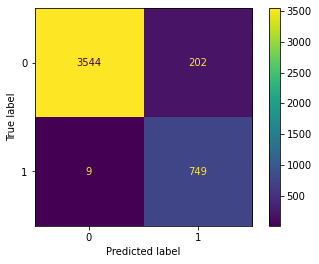

In [150]:
print('TRAIN dataset')
display(ConfusionMatrixDisplay.from_estimator(svc_model_best, X_train, y_train))

TEST dataset


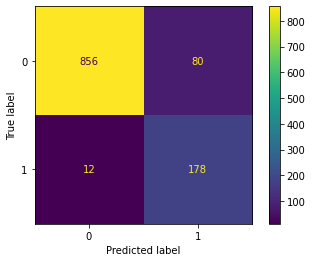

In [151]:
print('TEST dataset')
display(ConfusionMatrixDisplay.from_estimator(svc_model_best, X_test, y_test))

In [108]:
print(f'SVC model - kernel {svc_kernel}, penalty {svc_C}:')
print('--------------------------------------------')
print('Train dataset: ')
print('Classification report')
print(classification_report(y_train, y_pred_svc_tr))
print('----------------')
print(f'Accuracy: {accuracy_score(y_train, y_pred_svc_tr)}')
print(f'How many relevant cases are found? {recall_score(y_train, y_pred_svc_tr)}')
print(f'When prediction is positive, how often is it correct? {precision_score(y_train, y_pred_svc_tr)}')

print('--------------------------------------------')
print('Test dataset: ')
print('Classification report')
print(classification_report(y_test, y_pred_svc))
print('----------------')
print(f'Accuracy: {accuracy_score(y_test, y_pred_svc)}')
print(f'How many relevant cases are found? {recall_score(y_test, y_pred_svc)}')
print(f'When prediction is positive, how often is it correct? {precision_score(y_test, y_pred_svc)}')

SVC model - kernel rbf, penalty 2.9000000000000004:
--------------------------------------------
Train dataset: 
Classification report
              precision    recall  f1-score   support

           0       1.00      0.95      0.97      3746
           1       0.79      0.99      0.88       758

    accuracy                           0.95      4504
   macro avg       0.89      0.97      0.92      4504
weighted avg       0.96      0.95      0.96      4504

----------------
Accuracy: 0.9531527531083481
How many relevant cases are found? 0.9881266490765171
When prediction is positive, how often is it correct? 0.7875920084121977
--------------------------------------------
Test dataset: 
Classification report
              precision    recall  f1-score   support

           0       0.99      0.91      0.95       936
           1       0.69      0.94      0.79       190

    accuracy                           0.92      1126
   macro avg       0.84      0.93      0.87      1126
weighted av

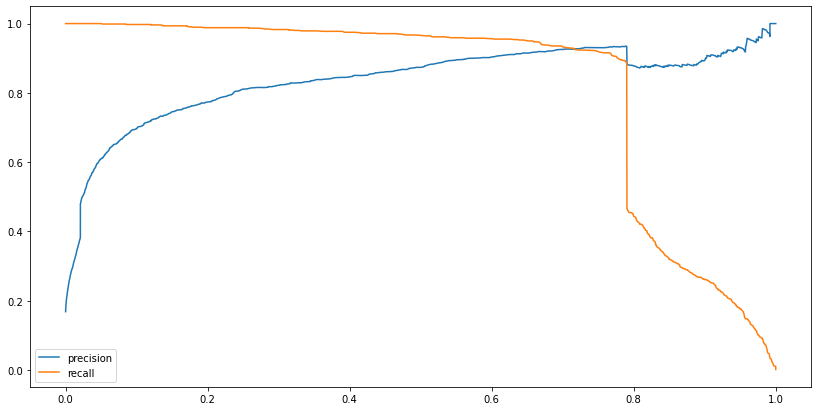

In [109]:
show_precision_recall(svc_model_best, X_train, y_train)

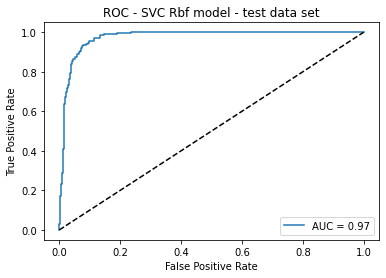

In [149]:
y_score_svc = svc_model_best.predict_proba(X_test)[:, 1]
fpr, tpr, thr = roc_curve(y_test, y_score_svc) 
roc_auc = auc(fpr, tpr)

RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()
plt.plot([0,1], [0,1], 'k--')
plt.title('ROC - SVC Rbf model - test data set')
plt.show()

In [111]:
filename = 'finalized_model_svc.sav'
joblib.dump(svc_model_best, filename)

['finalized_model_svc.sav']

#### Random Forest

In [112]:
rfc_gs = Pipeline(
    [
        ('cat_num_pipeline', cat_num_pipeline),
        ('model', RandomForestClassifier(oob_score=False))
    ]
)

In [113]:
rfc_gs.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'cat_num_pipeline', 'model', 'cat_num_pipeline__n_jobs', 'cat_num_pipeline__remainder', 'cat_num_pipeline__sparse_threshold', 'cat_num_pipeline__transformer_weights', 'cat_num_pipeline__transformers', 'cat_num_pipeline__verbose', 'cat_num_pipeline__verbose_feature_names_out', 'cat_num_pipeline__numerical', 'cat_num_pipeline__categorical', 'cat_num_pipeline__numerical__memory', 'cat_num_pipeline__numerical__steps', 'cat_num_pipeline__numerical__verbose', 'cat_num_pipeline__numerical__imputer', 'cat_num_pipeline__numerical__scaler', 'cat_num_pipeline__numerical__imputer__add_indicator', 'cat_num_pipeline__numerical__imputer__copy', 'cat_num_pipeline__numerical__imputer__fill_value', 'cat_num_pipeline__numerical__imputer__missing_values', 'cat_num_pipeline__numerical__imputer__strategy', 'cat_num_pipeline__numerical__imputer__verbose', 'cat_num_pipeline__numerical__scaler__copy', 'cat_num_pipeline__numerical__scaler__with_mean', 'cat_num_pipeline__

In [114]:
rfc_param_grid = [
    {
        "model__n_estimators": [64, 100, 128, 200],
        "model__max_features": ["auto", "log2"],
        "model__criterion":["gini", "entropy", "log_loss"],
        "model__min_samples_split":[10, 15, 20]
    }
]

In [115]:
rfc_grid_search = GridSearchCV(rfc_gs, rfc_param_grid, verbose=3)

In [116]:
rfc_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END model__criterion=gini, model__max_features=auto, model__min_samples_split=10, model__n_estimators=64;, score=0.928 total time=   0.2s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END model__criterion=gini, model__max_features=auto, model__min_samples_split=10, model__n_estimators=64;, score=0.922 total time=   0.2s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END model__criterion=gini, model__max_features=auto, model__min_samples_split=10, model__n_estimators=64;, score=0.925 total time=   0.2s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END model__criterion=gini, model__max_features=auto, model__min_samples_split=10, model__n_estimators=64;, score=0.927 total time=   0.2s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END model__criterion=gini, model__max_features=auto, model__min_samples_split=10, model__n_estimators=64;, score=0.920 total time=   0.2s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END model__criterion=gini, model__max_features=auto, model__min_samples_split=10, model__n_estimators=100;, score=0.935 total time=   0.4s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END model__criterion=gini, model__max_features=auto, model__min_samples_split=10, model__n_estimators=100;, score=0.921 total time=   0.4s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END model__criterion=gini, model__max_features=auto, model__min_samples_split=10, model__n_estimators=100;, score=0.933 total time=   0.3s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END model__criterion=gini, model__max_features=auto, model__min_samples_split=10, model__n_estimators=100;, score=0.937 total time=   0.4s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END model__criterion=gini, model__max_features=auto, model__min_samples_split=10, model__n_estimators=100;, score=0.916 total time=   0.4s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END model__criterion=gini, model__max_features=auto, model__min_samples_split=10, model__n_estimators=128;, score=0.929 total time=   0.5s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END model__criterion=gini, model__max_features=auto, model__min_samples_split=10, model__n_estimators=128;, score=0.922 total time=   0.5s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END model__criterion=gini, model__max_features=auto, model__min_samples_split=10, model__n_estimators=128;, score=0.936 total time=   0.6s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END model__criterion=gini, model__max_features=auto, model__min_samples_split=10, model__n_estimators=128;, score=0.937 total time=   0.5s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END model__criterion=gini, model__max_features=auto, model__min_samples_split=10, model__n_estimators=128;, score=0.914 total time=   0.6s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END model__criterion=gini, model__max_features=auto, model__min_samples_split=10, model__n_estimators=200;, score=0.926 total time=   0.7s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END model__criterion=gini, model__max_features=auto, model__min_samples_split=10, model__n_estimators=200;, score=0.923 total time=   0.7s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END model__criterion=gini, model__max_features=auto, model__min_samples_split=10, model__n_estimators=200;, score=0.933 total time=   0.8s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END model__criterion=gini, model__max_features=auto, model__min_samples_split=10, model__n_estimators=200;, score=0.932 total time=   1.4s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END model__criterion=gini, model__max_features=auto, model__min_samples_split=10, model__n_estimators=200;, score=0.914 total time=   1.2s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END model__criterion=gini, model__max_features=auto, model__min_samples_split=15, model__n_estimators=64;, score=0.917 total time=   0.3s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END model__criterion=gini, model__max_features=auto, model__min_samples_split=15, model__n_estimators=64;, score=0.912 total time=   0.2s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END model__criterion=gini, model__max_features=auto, model__min_samples_split=15, model__n_estimators=64;, score=0.925 total time=   0.2s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END model__criterion=gini, model__max_features=auto, model__min_samples_split=15, model__n_estimators=64;, score=0.923 total time=   0.2s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END model__criterion=gini, model__max_features=auto, model__min_samples_split=15, model__n_estimators=64;, score=0.902 total time=   0.2s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END model__criterion=gini, model__max_features=auto, model__min_samples_split=15, model__n_estimators=100;, score=0.916 total time=   0.4s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END model__criterion=gini, model__max_features=auto, model__min_samples_split=15, model__n_estimators=100;, score=0.917 total time=   0.5s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END model__criterion=gini, model__max_features=auto, model__min_samples_split=15, model__n_estimators=100;, score=0.930 total time=   0.4s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END model__criterion=gini, model__max_features=auto, model__min_samples_split=15, model__n_estimators=100;, score=0.927 total time=   0.5s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END model__criterion=gini, model__max_features=auto, model__min_samples_split=15, model__n_estimators=100;, score=0.910 total time=   0.4s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END model__criterion=gini, model__max_features=auto, model__min_samples_split=15, model__n_estimators=128;, score=0.912 total time=   0.6s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END model__criterion=gini, model__max_features=auto, model__min_samples_split=15, model__n_estimators=128;, score=0.909 total time=   0.7s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END model__criterion=gini, model__max_features=auto, model__min_samples_split=15, model__n_estimators=128;, score=0.919 total time=   0.5s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END model__criterion=gini, model__max_features=auto, model__min_samples_split=15, model__n_estimators=128;, score=0.927 total time=   0.5s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END model__criterion=gini, model__max_features=auto, model__min_samples_split=15, model__n_estimators=128;, score=0.910 total time=   0.4s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END model__criterion=gini, model__max_features=auto, model__min_samples_split=15, model__n_estimators=200;, score=0.918 total time=   0.8s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END model__criterion=gini, model__max_features=auto, model__min_samples_split=15, model__n_estimators=200;, score=0.911 total time=   0.7s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END model__criterion=gini, model__max_features=auto, model__min_samples_split=15, model__n_estimators=200;, score=0.923 total time=   0.7s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END model__criterion=gini, model__max_features=auto, model__min_samples_split=15, model__n_estimators=200;, score=0.921 total time=   0.7s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END model__criterion=gini, model__max_features=auto, model__min_samples_split=15, model__n_estimators=200;, score=0.911 total time=   0.6s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END model__criterion=gini, model__max_features=auto, model__min_samples_split=20, model__n_estimators=64;, score=0.911 total time=   0.2s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END model__criterion=gini, model__max_features=auto, model__min_samples_split=20, model__n_estimators=64;, score=0.906 total time=   0.2s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END model__criterion=gini, model__max_features=auto, model__min_samples_split=20, model__n_estimators=64;, score=0.920 total time=   0.1s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END model__criterion=gini, model__max_features=auto, model__min_samples_split=20, model__n_estimators=64;, score=0.913 total time=   0.2s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END model__criterion=gini, model__max_features=auto, model__min_samples_split=20, model__n_estimators=64;, score=0.899 total time=   0.2s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END model__criterion=gini, model__max_features=auto, model__min_samples_split=20, model__n_estimators=100;, score=0.909 total time=   0.3s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END model__criterion=gini, model__max_features=auto, model__min_samples_split=20, model__n_estimators=100;, score=0.909 total time=   0.4s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END model__criterion=gini, model__max_features=auto, model__min_samples_split=20, model__n_estimators=100;, score=0.920 total time=   0.3s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END model__criterion=gini, model__max_features=auto, model__min_samples_split=20, model__n_estimators=100;, score=0.921 total time=   0.3s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END model__criterion=gini, model__max_features=auto, model__min_samples_split=20, model__n_estimators=100;, score=0.897 total time=   0.3s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END model__criterion=gini, model__max_features=auto, model__min_samples_split=20, model__n_estimators=128;, score=0.907 total time=   0.4s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END model__criterion=gini, model__max_features=auto, model__min_samples_split=20, model__n_estimators=128;, score=0.905 total time=   0.4s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END model__criterion=gini, model__max_features=auto, model__min_samples_split=20, model__n_estimators=128;, score=0.916 total time=   0.4s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END model__criterion=gini, model__max_features=auto, model__min_samples_split=20, model__n_estimators=128;, score=0.919 total time=   0.4s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END model__criterion=gini, model__max_features=auto, model__min_samples_split=20, model__n_estimators=128;, score=0.897 total time=   0.4s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END model__criterion=gini, model__max_features=auto, model__min_samples_split=20, model__n_estimators=200;, score=0.906 total time=   0.6s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END model__criterion=gini, model__max_features=auto, model__min_samples_split=20, model__n_estimators=200;, score=0.907 total time=   0.7s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END model__criterion=gini, model__max_features=auto, model__min_samples_split=20, model__n_estimators=200;, score=0.922 total time=   0.6s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END model__criterion=gini, model__max_features=auto, model__min_samples_split=20, model__n_estimators=200;, score=0.920 total time=   0.6s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END model__criterion=gini, model__max_features=auto, model__min_samples_split=20, model__n_estimators=200;, score=0.898 total time=   0.6s
[CV 1/5] END model__criterion=gini, model__max_features=log2, model__min_samples_split=10, model__n_estimators=64;, score=0.922 total time=   0.1s
[CV 2/5] END model__criterion=gini, model__max_features=log2, model__min_samples_split=10, model__n_estimators=64;, score=0.923 total time=   0.1s
[CV 3/5] END model__criterion=gini, model__max_features=log2, model__min_samples_split=10, model__n_estimators=64;, score=0.926 total time=   0.2s
[CV 4/5] END model__criterion=gini, model__max_features=log2, model__min_samples_split=10, model__n_estimators=64;, score=0.925 total time=   0.1s
[CV 5/5] END model__criterion=gini, model__max_features=log2, model__min_samples_split=10, model__n_estimators=64;, score=0.916 total time=   0.1s
[CV 1/5] END model__criterion=gini, model__max_features=log2, model__min_samples_split=10, model__n_estimators=100;, 

[CV 1/5] END model__criterion=gini, model__max_features=log2, model__min_samples_split=20, model__n_estimators=200;, score=0.907 total time=   0.6s
[CV 2/5] END model__criterion=gini, model__max_features=log2, model__min_samples_split=20, model__n_estimators=200;, score=0.898 total time=   0.6s
[CV 3/5] END model__criterion=gini, model__max_features=log2, model__min_samples_split=20, model__n_estimators=200;, score=0.911 total time=   0.6s
[CV 4/5] END model__criterion=gini, model__max_features=log2, model__min_samples_split=20, model__n_estimators=200;, score=0.921 total time=   0.5s
[CV 5/5] END model__criterion=gini, model__max_features=log2, model__min_samples_split=20, model__n_estimators=200;, score=0.894 total time=   0.5s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END model__criterion=entropy, model__max_features=auto, model__min_samples_split=10, model__n_estimators=64;, score=0.926 total time=   0.2s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END model__criterion=entropy, model__max_features=auto, model__min_samples_split=10, model__n_estimators=64;, score=0.916 total time=   0.2s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END model__criterion=entropy, model__max_features=auto, model__min_samples_split=10, model__n_estimators=64;, score=0.933 total time=   0.2s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END model__criterion=entropy, model__max_features=auto, model__min_samples_split=10, model__n_estimators=64;, score=0.925 total time=   0.2s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END model__criterion=entropy, model__max_features=auto, model__min_samples_split=10, model__n_estimators=64;, score=0.918 total time=   0.2s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END model__criterion=entropy, model__max_features=auto, model__min_samples_split=10, model__n_estimators=100;, score=0.927 total time=   0.3s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END model__criterion=entropy, model__max_features=auto, model__min_samples_split=10, model__n_estimators=100;, score=0.925 total time=   0.3s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END model__criterion=entropy, model__max_features=auto, model__min_samples_split=10, model__n_estimators=100;, score=0.931 total time=   0.3s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END model__criterion=entropy, model__max_features=auto, model__min_samples_split=10, model__n_estimators=100;, score=0.932 total time=   0.3s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END model__criterion=entropy, model__max_features=auto, model__min_samples_split=10, model__n_estimators=100;, score=0.914 total time=   0.3s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END model__criterion=entropy, model__max_features=auto, model__min_samples_split=10, model__n_estimators=128;, score=0.928 total time=   0.4s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END model__criterion=entropy, model__max_features=auto, model__min_samples_split=10, model__n_estimators=128;, score=0.921 total time=   0.5s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END model__criterion=entropy, model__max_features=auto, model__min_samples_split=10, model__n_estimators=128;, score=0.929 total time=   0.5s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END model__criterion=entropy, model__max_features=auto, model__min_samples_split=10, model__n_estimators=128;, score=0.936 total time=   0.5s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END model__criterion=entropy, model__max_features=auto, model__min_samples_split=10, model__n_estimators=128;, score=0.918 total time=   0.5s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END model__criterion=entropy, model__max_features=auto, model__min_samples_split=10, model__n_estimators=200;, score=0.929 total time=   0.8s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END model__criterion=entropy, model__max_features=auto, model__min_samples_split=10, model__n_estimators=200;, score=0.922 total time=   0.8s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END model__criterion=entropy, model__max_features=auto, model__min_samples_split=10, model__n_estimators=200;, score=0.936 total time=   0.7s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END model__criterion=entropy, model__max_features=auto, model__min_samples_split=10, model__n_estimators=200;, score=0.935 total time=   0.7s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END model__criterion=entropy, model__max_features=auto, model__min_samples_split=10, model__n_estimators=200;, score=0.913 total time=   0.7s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END model__criterion=entropy, model__max_features=auto, model__min_samples_split=15, model__n_estimators=64;, score=0.915 total time=   0.2s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END model__criterion=entropy, model__max_features=auto, model__min_samples_split=15, model__n_estimators=64;, score=0.916 total time=   0.2s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END model__criterion=entropy, model__max_features=auto, model__min_samples_split=15, model__n_estimators=64;, score=0.925 total time=   0.2s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END model__criterion=entropy, model__max_features=auto, model__min_samples_split=15, model__n_estimators=64;, score=0.926 total time=   0.2s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END model__criterion=entropy, model__max_features=auto, model__min_samples_split=15, model__n_estimators=64;, score=0.903 total time=   0.2s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END model__criterion=entropy, model__max_features=auto, model__min_samples_split=15, model__n_estimators=100;, score=0.922 total time=   0.3s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END model__criterion=entropy, model__max_features=auto, model__min_samples_split=15, model__n_estimators=100;, score=0.913 total time=   0.3s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END model__criterion=entropy, model__max_features=auto, model__min_samples_split=15, model__n_estimators=100;, score=0.926 total time=   0.3s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END model__criterion=entropy, model__max_features=auto, model__min_samples_split=15, model__n_estimators=100;, score=0.927 total time=   0.4s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END model__criterion=entropy, model__max_features=auto, model__min_samples_split=15, model__n_estimators=100;, score=0.907 total time=   0.4s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END model__criterion=entropy, model__max_features=auto, model__min_samples_split=15, model__n_estimators=128;, score=0.925 total time=   0.6s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END model__criterion=entropy, model__max_features=auto, model__min_samples_split=15, model__n_estimators=128;, score=0.917 total time=   0.5s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END model__criterion=entropy, model__max_features=auto, model__min_samples_split=15, model__n_estimators=128;, score=0.925 total time=   0.5s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END model__criterion=entropy, model__max_features=auto, model__min_samples_split=15, model__n_estimators=128;, score=0.922 total time=   0.5s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END model__criterion=entropy, model__max_features=auto, model__min_samples_split=15, model__n_estimators=128;, score=0.910 total time=   0.5s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END model__criterion=entropy, model__max_features=auto, model__min_samples_split=15, model__n_estimators=200;, score=0.919 total time=   0.8s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END model__criterion=entropy, model__max_features=auto, model__min_samples_split=15, model__n_estimators=200;, score=0.913 total time=   0.9s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END model__criterion=entropy, model__max_features=auto, model__min_samples_split=15, model__n_estimators=200;, score=0.926 total time=   0.9s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END model__criterion=entropy, model__max_features=auto, model__min_samples_split=15, model__n_estimators=200;, score=0.923 total time=   0.9s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END model__criterion=entropy, model__max_features=auto, model__min_samples_split=15, model__n_estimators=200;, score=0.906 total time=   0.8s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END model__criterion=entropy, model__max_features=auto, model__min_samples_split=20, model__n_estimators=64;, score=0.916 total time=   0.2s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END model__criterion=entropy, model__max_features=auto, model__min_samples_split=20, model__n_estimators=64;, score=0.908 total time=   0.3s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END model__criterion=entropy, model__max_features=auto, model__min_samples_split=20, model__n_estimators=64;, score=0.916 total time=   0.2s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END model__criterion=entropy, model__max_features=auto, model__min_samples_split=20, model__n_estimators=64;, score=0.926 total time=   0.2s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END model__criterion=entropy, model__max_features=auto, model__min_samples_split=20, model__n_estimators=64;, score=0.903 total time=   0.2s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END model__criterion=entropy, model__max_features=auto, model__min_samples_split=20, model__n_estimators=100;, score=0.910 total time=   0.4s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END model__criterion=entropy, model__max_features=auto, model__min_samples_split=20, model__n_estimators=100;, score=0.906 total time=   0.4s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END model__criterion=entropy, model__max_features=auto, model__min_samples_split=20, model__n_estimators=100;, score=0.915 total time=   0.3s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END model__criterion=entropy, model__max_features=auto, model__min_samples_split=20, model__n_estimators=100;, score=0.922 total time=   0.3s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END model__criterion=entropy, model__max_features=auto, model__min_samples_split=20, model__n_estimators=100;, score=0.906 total time=   0.3s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END model__criterion=entropy, model__max_features=auto, model__min_samples_split=20, model__n_estimators=128;, score=0.909 total time=   0.5s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END model__criterion=entropy, model__max_features=auto, model__min_samples_split=20, model__n_estimators=128;, score=0.903 total time=   0.4s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END model__criterion=entropy, model__max_features=auto, model__min_samples_split=20, model__n_estimators=128;, score=0.917 total time=   0.5s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END model__criterion=entropy, model__max_features=auto, model__min_samples_split=20, model__n_estimators=128;, score=0.921 total time=   0.5s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END model__criterion=entropy, model__max_features=auto, model__min_samples_split=20, model__n_estimators=128;, score=0.901 total time=   0.5s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END model__criterion=entropy, model__max_features=auto, model__min_samples_split=20, model__n_estimators=200;, score=0.909 total time=   0.7s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END model__criterion=entropy, model__max_features=auto, model__min_samples_split=20, model__n_estimators=200;, score=0.908 total time=   0.8s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END model__criterion=entropy, model__max_features=auto, model__min_samples_split=20, model__n_estimators=200;, score=0.919 total time=   0.8s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END model__criterion=entropy, model__max_features=auto, model__min_samples_split=20, model__n_estimators=200;, score=0.923 total time=   0.7s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END model__criterion=entropy, model__max_features=auto, model__min_samples_split=20, model__n_estimators=200;, score=0.902 total time=   0.7s
[CV 1/5] END model__criterion=entropy, model__max_features=log2, model__min_samples_split=10, model__n_estimators=64;, score=0.925 total time=   0.2s
[CV 2/5] END model__criterion=entropy, model__max_features=log2, model__min_samples_split=10, model__n_estimators=64;, score=0.919 total time=   0.2s
[CV 3/5] END model__criterion=entropy, model__max_features=log2, model__min_samples_split=10, model__n_estimators=64;, score=0.928 total time=   0.2s
[CV 4/5] END model__criterion=entropy, model__max_features=log2, model__min_samples_split=10, model__n_estimators=64;, score=0.928 total time=   0.2s
[CV 5/5] END model__criterion=entropy, model__max_features=log2, model__min_samples_split=10, model__n_estimators=64;, score=0.917 total time=   0.2s
[CV 1/5] END model__criterion=entropy, model__max_features=log2, model__min_samples_split=10, model

[CV 5/5] END model__criterion=entropy, model__max_features=log2, model__min_samples_split=20, model__n_estimators=128;, score=0.901 total time=   0.4s
[CV 1/5] END model__criterion=entropy, model__max_features=log2, model__min_samples_split=20, model__n_estimators=200;, score=0.910 total time=   0.6s
[CV 2/5] END model__criterion=entropy, model__max_features=log2, model__min_samples_split=20, model__n_estimators=200;, score=0.906 total time=   0.7s
[CV 3/5] END model__criterion=entropy, model__max_features=log2, model__min_samples_split=20, model__n_estimators=200;, score=0.910 total time=   0.6s
[CV 4/5] END model__criterion=entropy, model__max_features=log2, model__min_samples_split=20, model__n_estimators=200;, score=0.918 total time=   0.6s
[CV 5/5] END model__criterion=entropy, model__max_features=log2, model__min_samples_split=20, model__n_estimators=200;, score=0.900 total time=   0.6s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END model__criterion=log_loss, model__max_features=auto, model__min_samples_split=10, model__n_estimators=64;, score=0.929 total time=   0.2s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END model__criterion=log_loss, model__max_features=auto, model__min_samples_split=10, model__n_estimators=64;, score=0.922 total time=   0.2s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END model__criterion=log_loss, model__max_features=auto, model__min_samples_split=10, model__n_estimators=64;, score=0.931 total time=   0.2s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END model__criterion=log_loss, model__max_features=auto, model__min_samples_split=10, model__n_estimators=64;, score=0.928 total time=   0.2s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END model__criterion=log_loss, model__max_features=auto, model__min_samples_split=10, model__n_estimators=64;, score=0.920 total time=   0.2s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END model__criterion=log_loss, model__max_features=auto, model__min_samples_split=10, model__n_estimators=100;, score=0.926 total time=   0.4s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END model__criterion=log_loss, model__max_features=auto, model__min_samples_split=10, model__n_estimators=100;, score=0.927 total time=   0.3s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END model__criterion=log_loss, model__max_features=auto, model__min_samples_split=10, model__n_estimators=100;, score=0.932 total time=   0.3s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END model__criterion=log_loss, model__max_features=auto, model__min_samples_split=10, model__n_estimators=100;, score=0.937 total time=   0.3s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END model__criterion=log_loss, model__max_features=auto, model__min_samples_split=10, model__n_estimators=100;, score=0.916 total time=   0.3s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END model__criterion=log_loss, model__max_features=auto, model__min_samples_split=10, model__n_estimators=128;, score=0.930 total time=   0.5s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END model__criterion=log_loss, model__max_features=auto, model__min_samples_split=10, model__n_estimators=128;, score=0.925 total time=   0.5s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END model__criterion=log_loss, model__max_features=auto, model__min_samples_split=10, model__n_estimators=128;, score=0.937 total time=   0.4s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END model__criterion=log_loss, model__max_features=auto, model__min_samples_split=10, model__n_estimators=128;, score=0.932 total time=   0.5s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END model__criterion=log_loss, model__max_features=auto, model__min_samples_split=10, model__n_estimators=128;, score=0.917 total time=   0.5s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END model__criterion=log_loss, model__max_features=auto, model__min_samples_split=10, model__n_estimators=200;, score=0.929 total time=   0.7s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END model__criterion=log_loss, model__max_features=auto, model__min_samples_split=10, model__n_estimators=200;, score=0.926 total time=   0.8s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END model__criterion=log_loss, model__max_features=auto, model__min_samples_split=10, model__n_estimators=200;, score=0.937 total time=   0.8s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END model__criterion=log_loss, model__max_features=auto, model__min_samples_split=10, model__n_estimators=200;, score=0.935 total time=   0.7s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END model__criterion=log_loss, model__max_features=auto, model__min_samples_split=10, model__n_estimators=200;, score=0.917 total time=   0.7s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END model__criterion=log_loss, model__max_features=auto, model__min_samples_split=15, model__n_estimators=64;, score=0.926 total time=   0.2s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END model__criterion=log_loss, model__max_features=auto, model__min_samples_split=15, model__n_estimators=64;, score=0.910 total time=   0.2s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END model__criterion=log_loss, model__max_features=auto, model__min_samples_split=15, model__n_estimators=64;, score=0.929 total time=   0.2s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END model__criterion=log_loss, model__max_features=auto, model__min_samples_split=15, model__n_estimators=64;, score=0.926 total time=   0.2s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END model__criterion=log_loss, model__max_features=auto, model__min_samples_split=15, model__n_estimators=64;, score=0.916 total time=   0.3s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END model__criterion=log_loss, model__max_features=auto, model__min_samples_split=15, model__n_estimators=100;, score=0.920 total time=   0.5s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END model__criterion=log_loss, model__max_features=auto, model__min_samples_split=15, model__n_estimators=100;, score=0.912 total time=   0.4s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END model__criterion=log_loss, model__max_features=auto, model__min_samples_split=15, model__n_estimators=100;, score=0.925 total time=   0.3s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END model__criterion=log_loss, model__max_features=auto, model__min_samples_split=15, model__n_estimators=100;, score=0.923 total time=   0.3s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END model__criterion=log_loss, model__max_features=auto, model__min_samples_split=15, model__n_estimators=100;, score=0.912 total time=   0.3s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END model__criterion=log_loss, model__max_features=auto, model__min_samples_split=15, model__n_estimators=128;, score=0.917 total time=   0.4s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END model__criterion=log_loss, model__max_features=auto, model__min_samples_split=15, model__n_estimators=128;, score=0.917 total time=   0.5s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END model__criterion=log_loss, model__max_features=auto, model__min_samples_split=15, model__n_estimators=128;, score=0.925 total time=   0.4s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END model__criterion=log_loss, model__max_features=auto, model__min_samples_split=15, model__n_estimators=128;, score=0.927 total time=   0.4s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END model__criterion=log_loss, model__max_features=auto, model__min_samples_split=15, model__n_estimators=128;, score=0.903 total time=   0.4s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END model__criterion=log_loss, model__max_features=auto, model__min_samples_split=15, model__n_estimators=200;, score=0.919 total time=   0.7s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END model__criterion=log_loss, model__max_features=auto, model__min_samples_split=15, model__n_estimators=200;, score=0.912 total time=   0.7s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END model__criterion=log_loss, model__max_features=auto, model__min_samples_split=15, model__n_estimators=200;, score=0.925 total time=   0.7s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END model__criterion=log_loss, model__max_features=auto, model__min_samples_split=15, model__n_estimators=200;, score=0.928 total time=   0.8s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END model__criterion=log_loss, model__max_features=auto, model__min_samples_split=15, model__n_estimators=200;, score=0.909 total time=   0.8s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END model__criterion=log_loss, model__max_features=auto, model__min_samples_split=20, model__n_estimators=64;, score=0.909 total time=   0.2s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END model__criterion=log_loss, model__max_features=auto, model__min_samples_split=20, model__n_estimators=64;, score=0.910 total time=   0.2s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END model__criterion=log_loss, model__max_features=auto, model__min_samples_split=20, model__n_estimators=64;, score=0.922 total time=   0.2s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END model__criterion=log_loss, model__max_features=auto, model__min_samples_split=20, model__n_estimators=64;, score=0.926 total time=   0.2s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END model__criterion=log_loss, model__max_features=auto, model__min_samples_split=20, model__n_estimators=64;, score=0.897 total time=   0.2s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END model__criterion=log_loss, model__max_features=auto, model__min_samples_split=20, model__n_estimators=100;, score=0.911 total time=   0.3s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END model__criterion=log_loss, model__max_features=auto, model__min_samples_split=20, model__n_estimators=100;, score=0.915 total time=   0.3s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END model__criterion=log_loss, model__max_features=auto, model__min_samples_split=20, model__n_estimators=100;, score=0.925 total time=   0.3s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END model__criterion=log_loss, model__max_features=auto, model__min_samples_split=20, model__n_estimators=100;, score=0.921 total time=   0.3s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END model__criterion=log_loss, model__max_features=auto, model__min_samples_split=20, model__n_estimators=100;, score=0.904 total time=   0.3s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END model__criterion=log_loss, model__max_features=auto, model__min_samples_split=20, model__n_estimators=128;, score=0.907 total time=   0.5s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END model__criterion=log_loss, model__max_features=auto, model__min_samples_split=20, model__n_estimators=128;, score=0.901 total time=   0.4s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END model__criterion=log_loss, model__max_features=auto, model__min_samples_split=20, model__n_estimators=128;, score=0.920 total time=   0.5s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END model__criterion=log_loss, model__max_features=auto, model__min_samples_split=20, model__n_estimators=128;, score=0.922 total time=   0.5s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END model__criterion=log_loss, model__max_features=auto, model__min_samples_split=20, model__n_estimators=128;, score=0.903 total time=   0.4s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END model__criterion=log_loss, model__max_features=auto, model__min_samples_split=20, model__n_estimators=200;, score=0.911 total time=   0.7s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END model__criterion=log_loss, model__max_features=auto, model__min_samples_split=20, model__n_estimators=200;, score=0.908 total time=   0.7s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END model__criterion=log_loss, model__max_features=auto, model__min_samples_split=20, model__n_estimators=200;, score=0.918 total time=   0.8s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END model__criterion=log_loss, model__max_features=auto, model__min_samples_split=20, model__n_estimators=200;, score=0.927 total time=   0.7s


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END model__criterion=log_loss, model__max_features=auto, model__min_samples_split=20, model__n_estimators=200;, score=0.903 total time=   0.8s
[CV 1/5] END model__criterion=log_loss, model__max_features=log2, model__min_samples_split=10, model__n_estimators=64;, score=0.922 total time=   0.2s
[CV 2/5] END model__criterion=log_loss, model__max_features=log2, model__min_samples_split=10, model__n_estimators=64;, score=0.922 total time=   0.2s
[CV 3/5] END model__criterion=log_loss, model__max_features=log2, model__min_samples_split=10, model__n_estimators=64;, score=0.926 total time=   0.2s
[CV 4/5] END model__criterion=log_loss, model__max_features=log2, model__min_samples_split=10, model__n_estimators=64;, score=0.927 total time=   0.2s
[CV 5/5] END model__criterion=log_loss, model__max_features=log2, model__min_samples_split=10, model__n_estimators=64;, score=0.920 total time=   0.2s
[CV 1/5] END model__criterion=log_loss, model__max_features=log2, model__min_samples_split=10

[CV 4/5] END model__criterion=log_loss, model__max_features=log2, model__min_samples_split=20, model__n_estimators=128;, score=0.920 total time=   0.4s
[CV 5/5] END model__criterion=log_loss, model__max_features=log2, model__min_samples_split=20, model__n_estimators=128;, score=0.901 total time=   0.4s
[CV 1/5] END model__criterion=log_loss, model__max_features=log2, model__min_samples_split=20, model__n_estimators=200;, score=0.901 total time=   0.7s
[CV 2/5] END model__criterion=log_loss, model__max_features=log2, model__min_samples_split=20, model__n_estimators=200;, score=0.906 total time=   0.7s
[CV 3/5] END model__criterion=log_loss, model__max_features=log2, model__min_samples_split=20, model__n_estimators=200;, score=0.915 total time=   0.7s
[CV 4/5] END model__criterion=log_loss, model__max_features=log2, model__min_samples_split=20, model__n_estimators=200;, score=0.919 total time=   0.6s
[CV 5/5] END model__criterion=log_loss, model__max_features=log2, model__min_samples_spl

C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


GridSearchCV(estimator=Pipeline(steps=[('cat_num_pipeline',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['CityTier', 'Tenure', 'DaySinceLastOrder', 'CashbackAmount',
       'OrderCount', 'CouponUsed', 'WarehouseToHome', 'SatisfactionScore',
       'NumberOfAddress', 'NumberOf...
                                                                                          OneHotEncoder(sparse=False))]),
                                                                         Index(['PreferredLoginDevice', 'PreferredPaymentMode', 'PreferedOrderCat',
       'Gender', 'MaritalStatus'],
      dtype='object'))])),
                                       ('model', RandomForestClassifier())]),
             param_grid=[{'model__criterion': ['gini', 'entropy', 'log_loss'],
                          'model__max_features': ['auto', 'log2'],
                          'model__min_samples_split': [10, 15, 20],
                          'model__n_estimators': [64, 100, 128, 200]}],
             verbose=3)

In [117]:
rfc_grid_search_results = pd.DataFrame(rfc_grid_search.cv_results_)
rfc_grid_search_results.sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__criterion,param_model__max_features,param_model__min_samples_split,param_model__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
51,0.796201,0.022448,0.050555,0.003599,log_loss,auto,10,200,"{'model__criterion': 'log_loss', 'model__max_f...",0.928968,0.925638,0.936737,0.934517,0.916667,0.928505,0.007106,1
1,0.442185,0.017587,0.032665,0.001458,gini,auto,10,100,"{'model__criterion': 'gini', 'model__max_featu...",0.934517,0.921199,0.933407,0.936737,0.915556,0.928283,0.008352,2
50,0.526032,0.017539,0.033065,0.000381,log_loss,auto,10,128,"{'model__criterion': 'log_loss', 'model__max_f...",0.930078,0.924528,0.936737,0.932297,0.916667,0.928061,0.006922,3
2,0.570871,0.043489,0.039355,0.001124,gini,auto,10,128,"{'model__criterion': 'gini', 'model__max_featu...",0.928968,0.922309,0.935627,0.936737,0.914444,0.927617,0.008377,4
49,0.407868,0.009417,0.027732,0.001398,log_loss,auto,10,100,"{'model__criterion': 'log_loss', 'model__max_f...",0.925638,0.926748,0.932297,0.936737,0.915556,0.927395,0.007141,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,0.730018,0.039693,0.053196,0.007023,log_loss,log2,20,200,"{'model__criterion': 'log_loss', 'model__max_f...",0.901221,0.905660,0.914539,0.918979,0.895556,0.907191,0.008559,67
69,0.352830,0.006740,0.027624,0.000837,log_loss,log2,20,100,"{'model__criterion': 'log_loss', 'model__max_f...",0.906770,0.904550,0.908990,0.914539,0.897778,0.906526,0.005491,69
23,0.606086,0.013989,0.046378,0.000723,gini,log2,20,200,"{'model__criterion': 'gini', 'model__max_featu...",0.906770,0.897891,0.911210,0.921199,0.894444,0.906303,0.009566,70
44,0.236585,0.019679,0.021828,0.001547,entropy,log2,20,64,"{'model__criterion': 'entropy', 'model__max_fe...",0.903441,0.903441,0.911210,0.911210,0.897778,0.905416,0.005163,71


In [118]:
rfc_grid_search.best_params_

{'model__criterion': 'log_loss',
 'model__max_features': 'auto',
 'model__min_samples_split': 10,
 'model__n_estimators': 200}

In [119]:
n_estimators = rfc_grid_search.best_params_['model__n_estimators']
criterion = rfc_grid_search.best_params_['model__criterion']
max_features = rfc_grid_search.best_params_['model__max_features']
min_samples_split = rfc_grid_search.best_params_['model__min_samples_split']

In [120]:
rfc_best_model = Pipeline(
    [
        ('cat_num_pipeline', cat_num_pipeline),
        ('model', RandomForestClassifier(n_estimators=n_estimators, criterion=criterion,
                                         max_features=max_features, min_samples_split=min_samples_split))
    ]
)

rfc_best_model.fit(X_train, y_train)

C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Pipeline(steps=[('cat_num_pipeline',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['CityTier', 'Tenure', 'DaySinceLastOrder', 'CashbackAmount',
       'OrderCount', 'CouponUsed', 'WarehouseToHome', 'SatisfactionScore',
       'NumberOfAddress', 'NumberOfDeviceRegistered', 'Comp...
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(sparse=False))]),
                                                  Index(['PreferredLoginDevice', 'PreferredPaymentMode', 'PreferedOrderCat',
       'Gender', 'MaritalStatus'],
      dtype='object'))])),
                ('model',
                 RandomForestClassifier(criterion='log_loss',
                                        max_features='auto',
                                        min_samples_split=10,
                                        n_estimators=200))])

In [124]:
y_score_rfc = rfc_best_model.predict_proba(X_test)[:,1]
y_train__rfc_pred = rfc_best_model.predict(X_train)
y_pred_rfc = rfc_best_model.predict(X_test)

In [125]:
results = pd.DataFrame({'probability': y_score_rfc,
            'y_test':y_test,
            'y_pred':y_pred_rfc,
            'Tenure': X_test['Tenure'],
            'DaySinceLastOrder': X_test['DaySinceLastOrder'],
            'CashbackAmount': X_test['CashbackAmount'],
            'OrderCount': X_test['OrderCount'],
            'CouponUsed': X_test['CouponUsed'],
            'WarehouseToHome': X_test['WarehouseToHome'],
            'SatisfactionScore': X_test['SatisfactionScore'],   
            'Complain': X_test['Complain'], 
            'PreferredPaymentMode': X_test['PreferredPaymentMode'],
            'PreferedOrderCat': X_test['PreferedOrderCat'],   
            'Gender': X_test['Gender'],   
            'MaritalStatus': X_test['MaritalStatus']})
                        
                        
                        
results[y_test != y_pred_rfc]

,probability,y_test,y_pred,Tenure,DaySinceLastOrder,CashbackAmount,OrderCount,CouponUsed,WarehouseToHome,SatisfactionScore,Complain,PreferredPaymentMode,PreferedOrderCat,Gender,MaritalStatus
5216,0.471977,1,0,1.0,3.0,154,2.0,2.0,8.0,3,0,COD,Mobile Phone,Male,Married
4377,0.472985,1,0,1.0,6.0,146,2.0,1.0,7.0,3,0,COD,Mobile Phone,Male,Single
2825,0.204895,1,0,5.0,9.0,320,16.0,10.0,19.0,3,0,COD,Others,Female,Single
2456,0.283437,1,0,16.0,9.0,202,1.0,0.0,8.0,1,0,COD,Fashion,Female,Married
2834,0.419976,1,0,20.0,4.0,175,5.0,2.0,21.0,4,1,Debit Card,Mobile Phone,Female,Single
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3630,0.352978,1,0,3.0,4.0,164,2.0,1.0,30.0,5,0,CC,Mobile Phone,Male,Single
2005,0.499124,1,0,20.0,0.0,124,1.0,1.0,NaN,1,1,Debit Card,Mobile,Male,Married
192,0.168177,1,0,15.0,7.0,149,7.0,7.0,14.0,4,0,CC,Laptop & Accessory,Male,Single
470,0.457219,1,0,20.0,8.0,292,13.0,5.0,8.0,4,1,Debit Card,Others,Male,Single


TRAIN dataset


TEST dataset


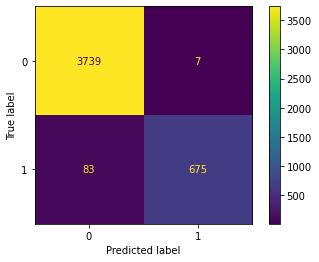

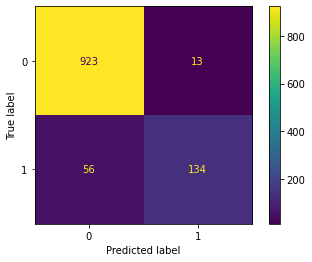

In [126]:
print('TRAIN dataset')
display(ConfusionMatrixDisplay.from_estimator(rfc_best_model, X_train, y_train))
print('TEST dataset')
display(ConfusionMatrixDisplay.from_estimator(rfc_best_model, X_test, y_test))

In [127]:
print("\n\nTRAIN")
print(classification_report(y_train, y_train__rfc_pred))

print("TEST")
print(classification_report(y_test, y_pred_rfc))



TRAIN
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3746
           1       0.99      0.89      0.94       758

    accuracy                           0.98      4504
   macro avg       0.98      0.94      0.96      4504
weighted avg       0.98      0.98      0.98      4504

TEST
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       936
           1       0.91      0.71      0.80       190

    accuracy                           0.94      1126
   macro avg       0.93      0.85      0.88      1126
weighted avg       0.94      0.94      0.94      1126



In [128]:
filename = 'finalized_model_rfc.sav'
joblib.dump(rfc_best_model, filename)

['finalized_model_rfc.sav']

## Model Comparison

In [129]:
print("TRAIN")
print('--------------------------------------------')
print('Logistic Regresion: ')
print(classification_report(y_train, y_pred_lg_tr))
print('--------------------------------------------')
print(f'SVC model - kernel {svc_kernel}, penalty {svc_C}:')
print('Classification report')
print(classification_report(y_train, y_pred_svc_tr))

print('--------------------------------------------')
print("Random Forest")
print(classification_report(y_train, y_train__rfc_pred))

TRAIN
--------------------------------------------
Logistic Regresion: 
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      3746
           1       0.77      0.54      0.63       758

    accuracy                           0.90      4504
   macro avg       0.84      0.75      0.79      4504
weighted avg       0.89      0.90      0.89      4504

--------------------------------------------
SVC model - kernel rbf, penalty 2.9000000000000004:
Classification report
              precision    recall  f1-score   support

           0       1.00      0.95      0.97      3746
           1       0.79      0.99      0.88       758

    accuracy                           0.95      4504
   macro avg       0.89      0.97      0.92      4504
weighted avg       0.96      0.95      0.96      4504

--------------------------------------------
Random Forest
              precision    recall  f1-score   support

           0       0.98      1.00      0.

In [130]:
print("TEST")
print('--------------------------------------------')
print('Logistic Regresion: ')
print(classification_report(y_test, y_pred_lg))
print('--------------------------------------------')
print(classification_report(y_test, y_pred_svc))
print('--------------------------------------------')
print("Random Forest")
print(classification_report(y_test, y_pred_rfc))

TEST
--------------------------------------------
Logistic Regresion: 
              precision    recall  f1-score   support

           0       0.91      0.96      0.93       936
           1       0.73      0.53      0.62       190

    accuracy                           0.89      1126
   macro avg       0.82      0.75      0.78      1126
weighted avg       0.88      0.89      0.88      1126

--------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.91      0.95       936
           1       0.69      0.94      0.79       190

    accuracy                           0.92      1126
   macro avg       0.84      0.93      0.87      1126
weighted avg       0.94      0.92      0.92      1126

--------------------------------------------
Random Forest
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       936
           1       0.91      0.71      0.80       190

    acc

## Model selection

SVC is chosen as a target model due to its high and stable performance on test and train data sets in context of f1 score and recall.